In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
legacy = 'legacy_transactions_data.csv'
recent = 'recent_transactions_data.csv'

In [4]:
df = pd.read_csv(legacy)
recent_df = pd.read_csv(recent)

In [5]:
pd.set_option('display.max_rows', 10)

In [6]:
training_range = pd.date_range('2019-03-01', '2020-02-29')
testing_date_range = pd.date_range('2021-03-01', '2022-02-28')
testing_range = pd.date_range('2021-03-01', '2022-03-06', freq='W-SUN')

In [7]:
def week_of_month(sunday):
    return (sunday.day - 1) // 7 + 1

In [8]:
def data_for_item(item_code, val = 0):
    filtered_df = df.loc[df['ItemCode'] == item_code]
    filtered_df["DateID"] = pd.to_datetime(filtered_df["DateID"], format = "%m/%d/%Y")
        
    filtered_df.set_index(filtered_df.DateID, inplace=True)
    filtered_df.drop('DateID', axis=1, inplace=True)
    filtered_df.drop('ItemCode', axis = 1, inplace = True)
    filtered_df.drop('CategoryCode', axis = 1, inplace = True)
    
    for date in training_range:
        if date not in filtered_df.index:
            filtered_df.loc[date] = [0]
    
    filtered_df = filtered_df.sort_index()
        
    weekly_sales = filtered_df.groupby(pd.Grouper(freq='W')).sum()
    weekly_sales.rename(columns = {'DailySales': 'WeeklySales'}, inplace = True)
    weekly_sales = create_lag(weekly_sales)
    weekly_sales['month'] = weekly_sales.index.month
    weekly_sales['week'] = weekly_sales.index.map(week_of_month)
    
    if val > 0:
        weekly_sales, val_sales = weekly_sales.iloc[:-val, :], weekly_sales.iloc[-val:, :]
        
    train_x = weekly_sales.loc[:, weekly_sales.columns != 'WeeklySales']
    train_y = weekly_sales['WeeklySales']
    
    if val > 0:
        return (weekly_sales, train_x, train_y), val_sales
    else:
        return (weekly_sales, train_x, train_y), None
    

In [9]:
def data_for_item_recent(item_code):
    filtered_df = recent_df.loc[recent_df['ItemCode'] == item_code]
    filtered_df["DateID"] = pd.to_datetime(filtered_df["DateID"], format = "%m/%d/%Y")
        
    filtered_df.set_index(filtered_df.DateID, inplace=True)
    filtered_df.drop('DateID', axis=1, inplace=True)
    filtered_df.drop('ItemCode', axis = 1, inplace = True)
    filtered_df.drop('CategoryCode', axis = 1, inplace = True)
    
    for date in testing_date_range:
        if date not in filtered_df.index:
            filtered_df.loc[date] = [0]
    
    filtered_df = filtered_df.sort_index()
        
    weekly_sales = filtered_df.groupby(pd.Grouper(freq='W')).sum()
    weekly_sales.rename(columns = {'DailySales': 'WeeklySales'}, inplace = True)
    return weekly_sales

In [10]:
def create_lag(df3):
    dataframe = pd.DataFrame()
    for i in range(4, 0, -1):
        dataframe['lag-' + str(i)] = df3.WeeklySales.shift(i)
    df4 = pd.concat([df3, dataframe], axis=1)
    df4.dropna(inplace=True)
    return df4

In [11]:
(weekly_sales, train_x, train_y), val_sales = data_for_item(255299, 4)
val_sales

WeeklySales  lag-4  lag-3  lag-2  lag-1  month  week
DateID                                                          
2020-02-09           39   36.0   38.0   37.0   46.0      2     2
2020-02-16           42   38.0   37.0   46.0   39.0      2     3
2020-02-23           35   37.0   46.0   39.0   42.0      2     4
2020-03-01           23   46.0   39.0   42.0   35.0      3     1

In [13]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [14]:
train_errors = {}
val_errors = {}

In [15]:
def train_predict(weekly_sales, train_x, train_y, testing_range = testing_range):
    model = RandomForestRegressor(random_state = 10)

    fit = model.fit(train_x, train_y)
    results = []
    
    train_pred = fit.predict(train_x)
    train_error = accuracy(train_y.values, train_pred)
    
    for date in testing_range:
        prev_row = weekly_sales.iloc[-1]
        test_x = pd.DataFrame({'lag-4': [prev_row['lag-3']],
                                'lag-3': [prev_row['lag-2']],
                                'lag-2': [prev_row['lag-1']],
                               'lag-1':[prev_row['WeeklySales']], 
                               'month': [date.month], 
                               'week': [week_of_month(date)]
                               })
        prediction = round(fit.predict(test_x)[0])
        test_x['WeeklySales'] = [prediction]
        test_x.index = [date]
        #print(test_x)
        weekly_sales = weekly_sales.append(test_x)
        results.append(prediction)
    
    #print(weekly_sales)
    return results, train_error
        

In [38]:
def predict_for_one_item(item_code, val = 0):
    (weekly_sales, train_x, train_y), val_sales = data_for_item(item_code, val)
    if val > 0:
        result, error = train_predict(weekly_sales, train_x, train_y, val_sales.index)
    else:
        result, error = train_predict(weekly_sales, train_x, train_y)
    
    print("Item {} Training error: {}".format(item_code, error))
    if val > 0:
        val_error = accuracy(val_sales.WeeklySales, np.array(result))
        print("Validation error: {}".format(val_error))
        if val_error < float('inf'):
            val_errors[item_code] = val_error
    train_errors[item_code] = error
    
    if val == 0:
        return pd.DataFrame({'PredictedSales': result}, index = testing_range)

In [19]:
predict_for_one_item(705797, 4)

Item 705797 Training error: 0.08944732937685457 Validation error: inf


In [18]:
def accuracy(actual, pred):
    diff = np.sum(np.abs(actual - pred))
    return diff / np.sum(actual)

In [20]:
def predict_for_all_validate(val = 4):
    global train_errors, val_errors
    train_errors = {}
    val_errors = {}
    items = df.ItemCode.unique()
    
    for item in items:
        predict_for_one_item(item, val)
    print("Average validation error: {}".format(sum(val_errors.values())/len(val_errors)))

In [124]:
predict_for_all_validate()

In [127]:
sum(val_errors.values()) / len(val_errors)

In [21]:
def predict_for_all():
    global train_errors
    train_errors = {}
    val_errors = {}
    items = df.ItemCode.unique()
    
    for item in items:
        predict_for_one_item(item, val)
    print("Average validation error: {}".format(sum(val_errors.values())/len(val_errors)))

In [146]:
useful = [692861,24587,255377]
#255377 face masks

In [30]:
def data_for_item_sales(item_code):
    filtered_df = df.loc[df['ItemCode'] == item_code]
    filtered_df["DateID"] = pd.to_datetime(filtered_df["DateID"], format = "%m/%d/%Y")
        
    filtered_df.set_index(filtered_df.DateID, inplace=True)
    filtered_df.drop('DateID', axis=1, inplace=True)
    filtered_df.drop('ItemCode', axis = 1, inplace = True)
    filtered_df.drop('CategoryCode', axis = 1, inplace = True)
    
    for date in training_range:
        if date not in filtered_df.index:
            filtered_df.loc[date] = [0]
    
    filtered_df = filtered_df.sort_index()
        
    weekly_sales = filtered_df.groupby(pd.Grouper(freq='W')).sum()
    weekly_sales.rename(columns = {'DailySales': 'WeeklySales'}, inplace = True)
    return weekly_sales

In [37]:
def plot(item):
    train_y = data_for_item_sales(item).WeeklySales
    predictions = predict_for_one_item(item)
    recent_sales = data_for_item_recent(item)

    fig, axs = plt.subplots(1, 2,figsize=(20, 4), sharey = True)
    predictions.plot(ax = axs[0])
    recent_sales.plot(ax = axs[0])
    axs[0].set(xlabel = "", ylabel = "Weekly Sales", title = "Recent sales of item {}".format(item))

    train_y.plot(ax = axs[1])
    axs[1].set(xlabel = "", ylabel = "Weekly Sales", title = "Legacy sales of item {}".format(item))
    plt.savefig("graphs/{}.png".format(item))

Item 28445 Training error: 0.08748701373658085


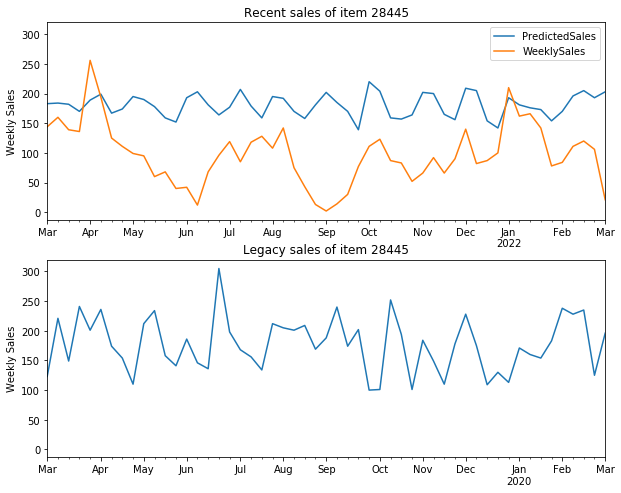

In [43]:
item = 28445

train_y = data_for_item_sales(item).WeeklySales
predictions = predict_for_one_item(item)
recent_sales = data_for_item_recent(item)

fig, axs = plt.subplots(2, 1,figsize=(10, 8), sharey = True)
predictions.plot(ax = axs[0])
recent_sales.plot(ax = axs[0])
axs[0].set(xlabel = "", ylabel = "Weekly Sales", title = "Recent sales of item {}".format(item))

train_y.plot(ax = axs[1])
axs[1].set(xlabel = "", ylabel = "Weekly Sales", title = "Legacy sales of item {}".format(item))
plt.savefig("graphs/{}.png".format(item))

Item 255299 Training error: 0.06736526946107783
Item 73535 Training error: 0.12426195426195424
Item 29627 Training error: 0.09240381453469254
Item 661781 Training error: 0.09586025364919837
Item 577277 Training error: 0.13159918570459175
Item 609011 Training error: 0.10327706057596821
Item 255377 Training error: 0.07000771010023132
Item 66041 Training error: 0.1359708485163977
Item 707747 Training error: 0.09539744537105456
Item 568793 Training error: 0.11248677248677247
Item 692861 Training error: 0.06751269035532995
Item 25667 Training error: 0.10887528691660292
Item 24527 Training error: 0.05838419861463548
Item 105545 Training error: 0.14101288429646638
Item 558617 Training error: 0.08801721284342932
Item 78677 Training error: 0.18286367098248285
Item 668759 Training error: 0.17231213872832368
Item 583109 Training error: 0.19297642436149312
Item 692843 Training error: 0.0703125
Item 27161 Training error: 0.1484826847554445
Item 711383 Training error: 0.12229740615434187
Item 596207

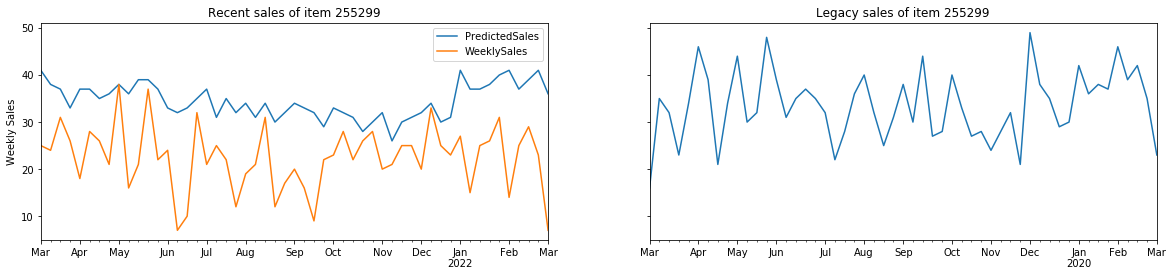

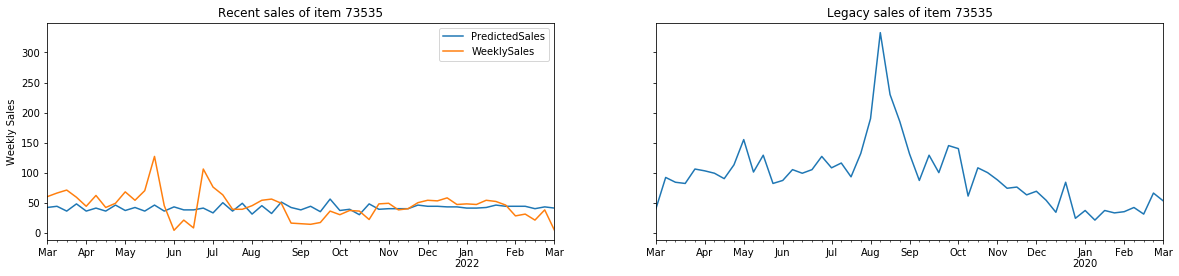

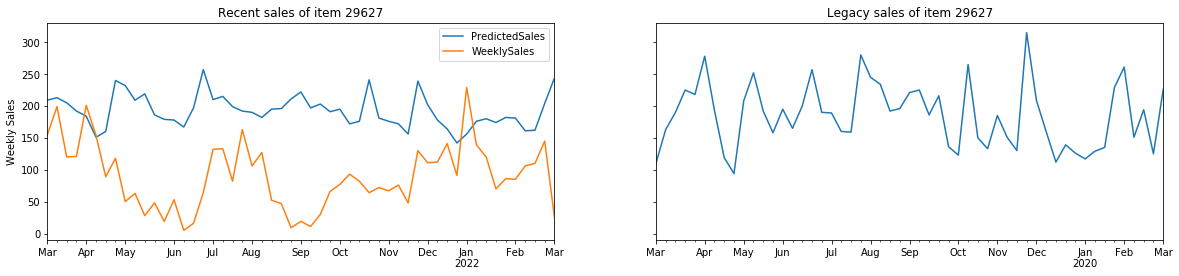

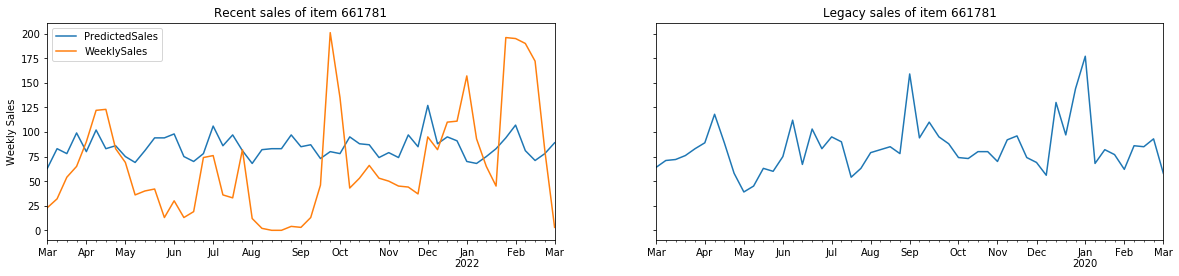

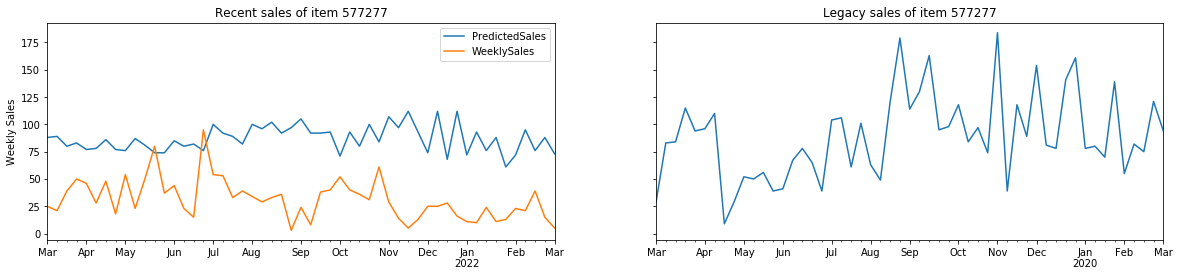

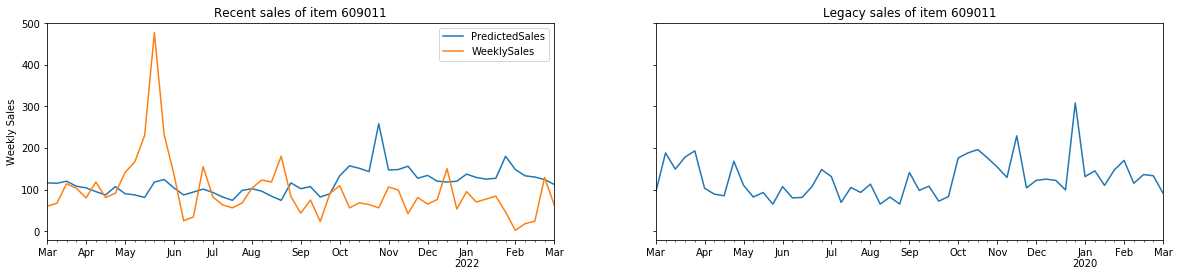

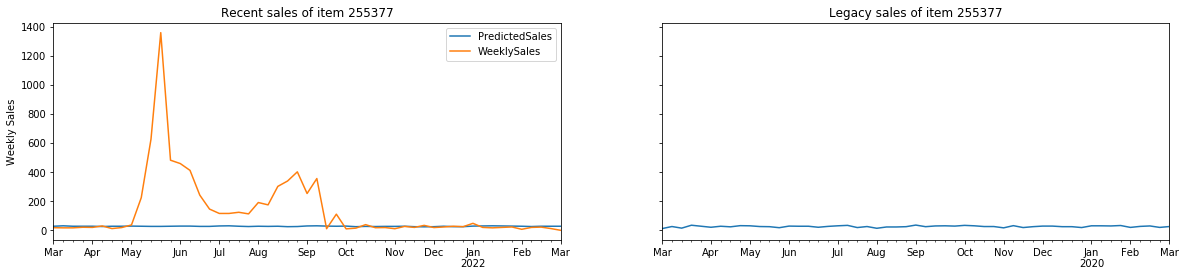

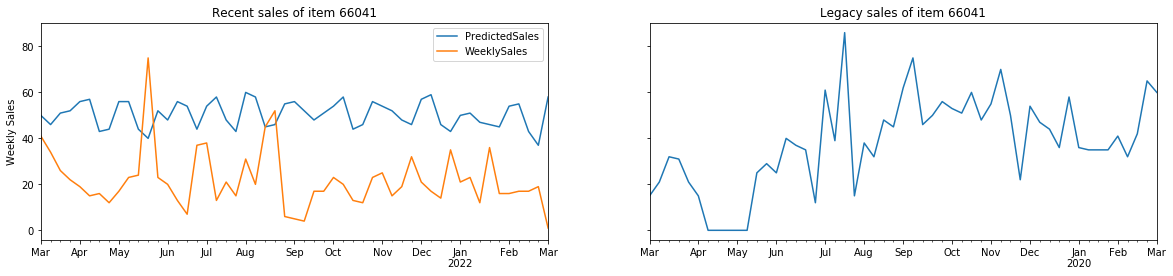

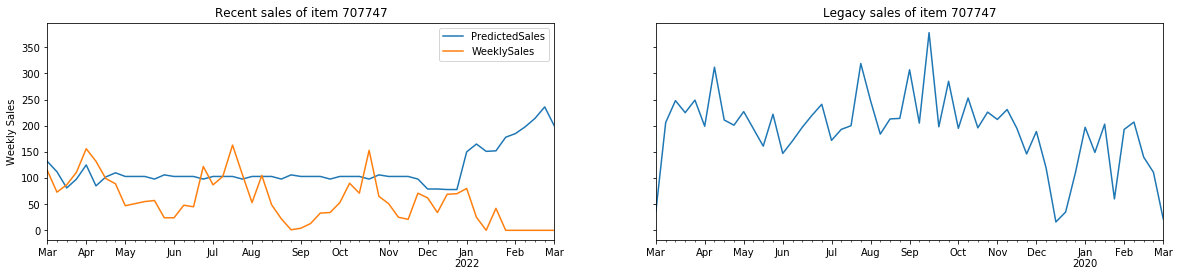

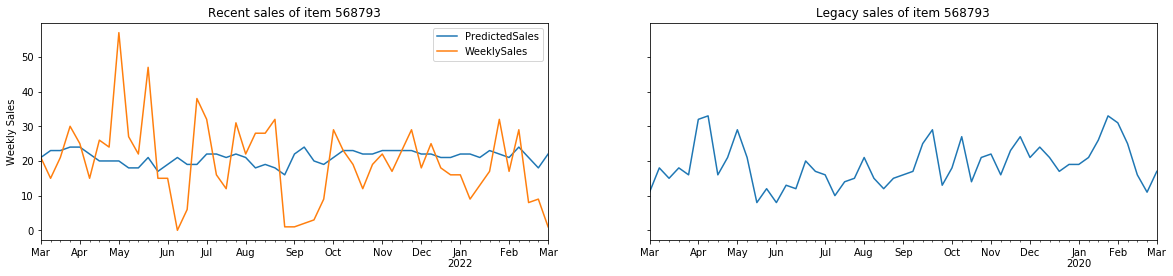

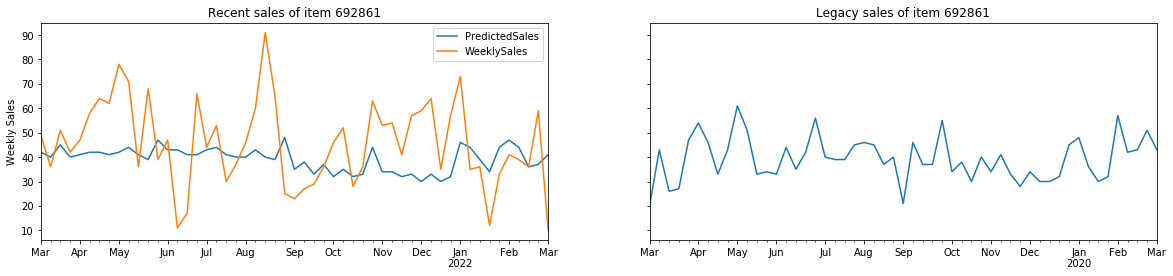

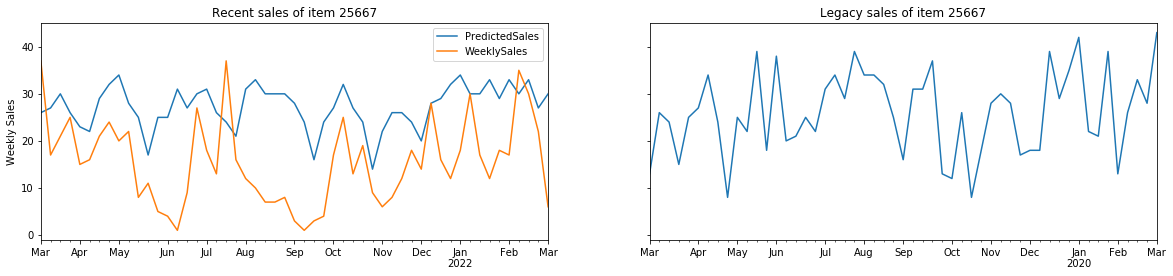

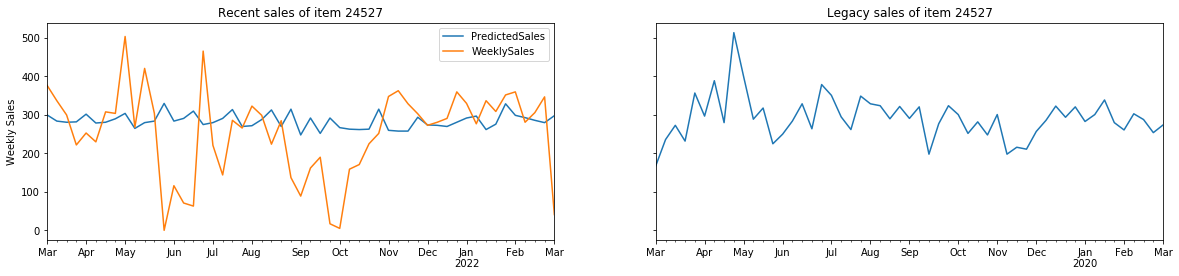

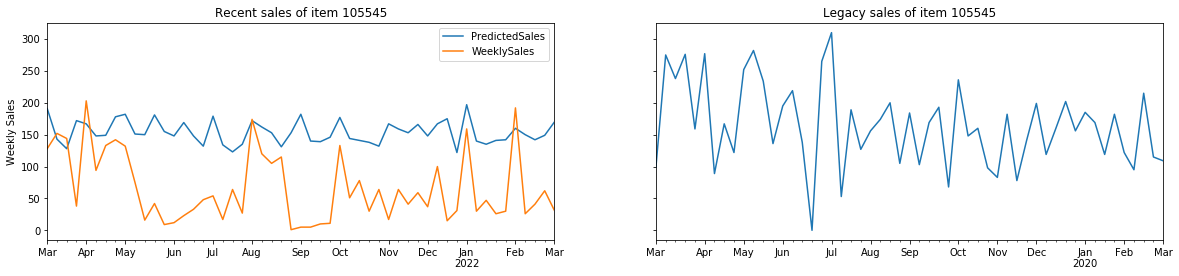

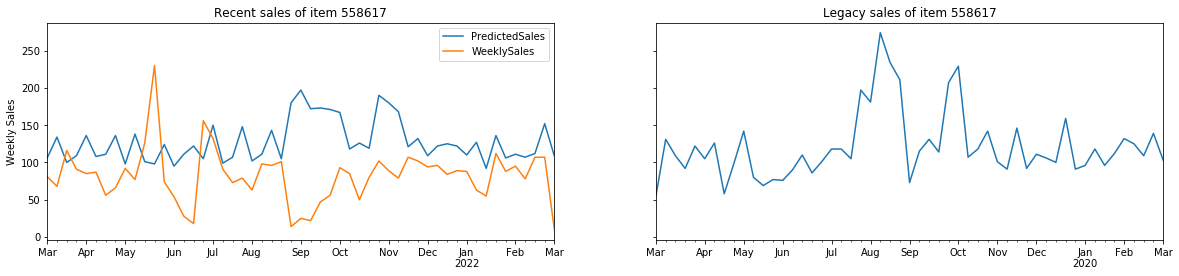

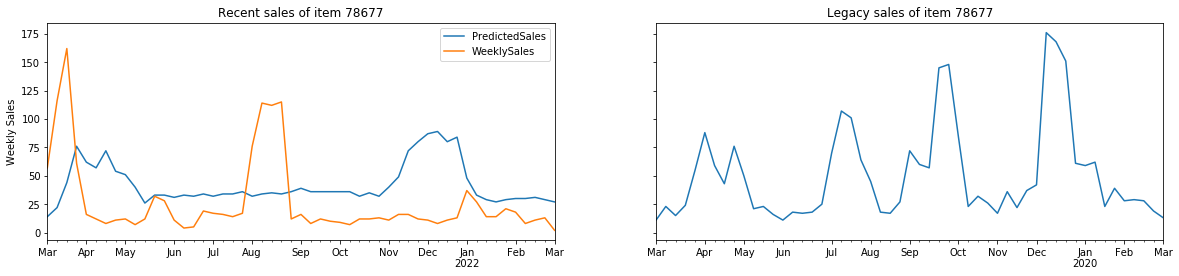

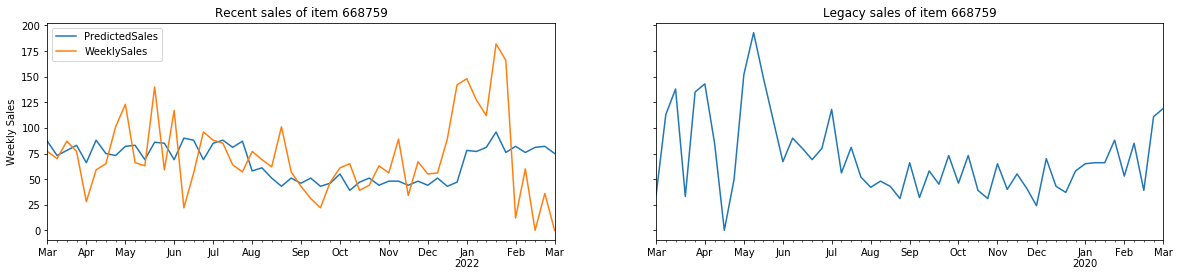

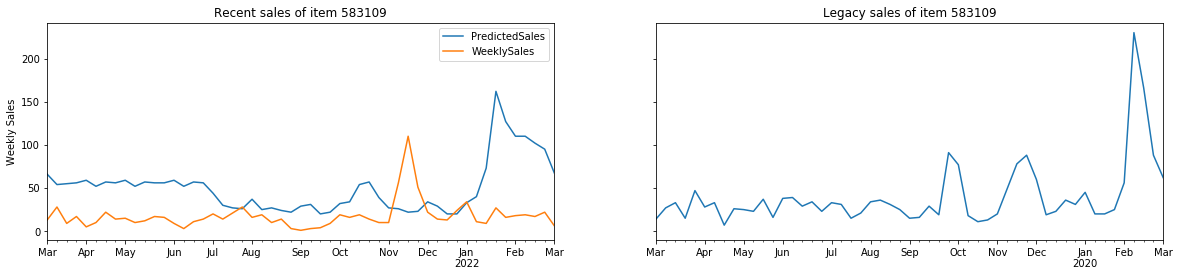

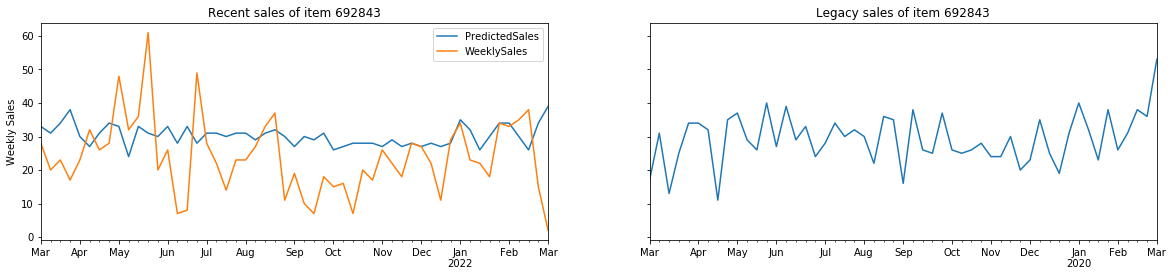

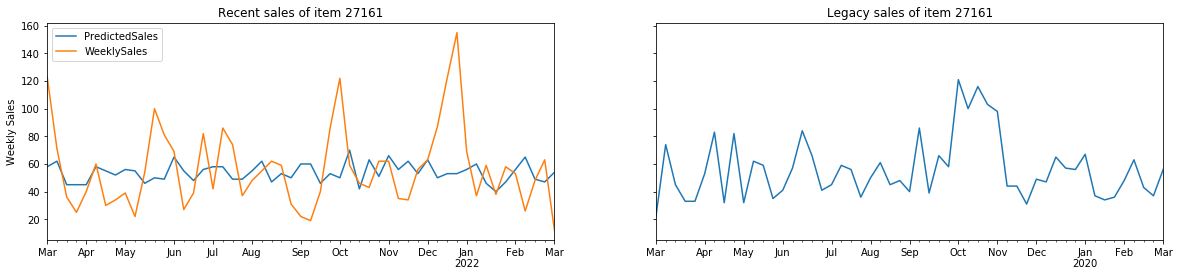

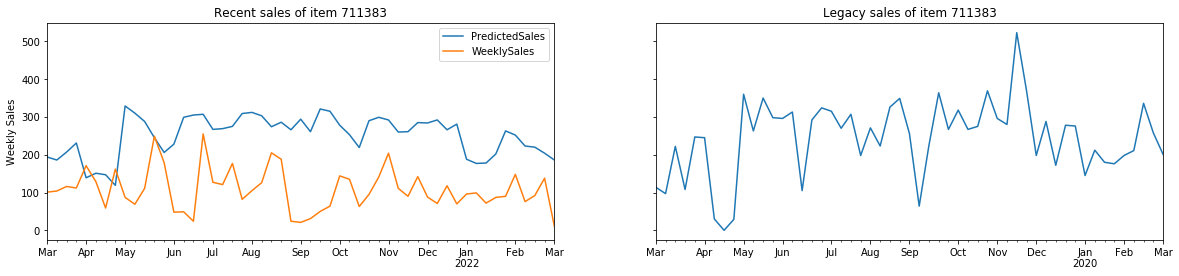

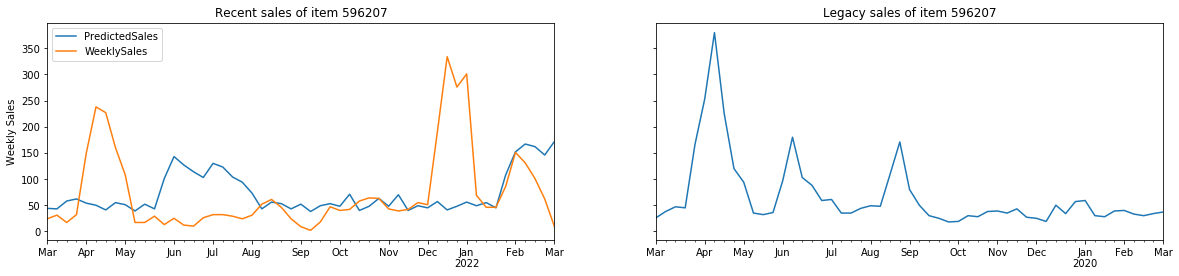

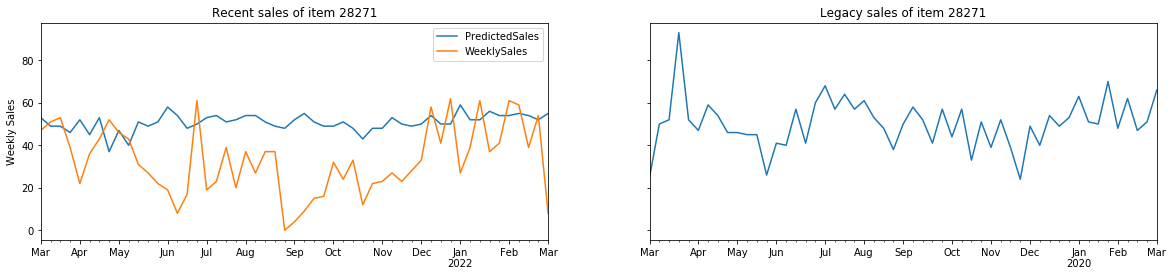

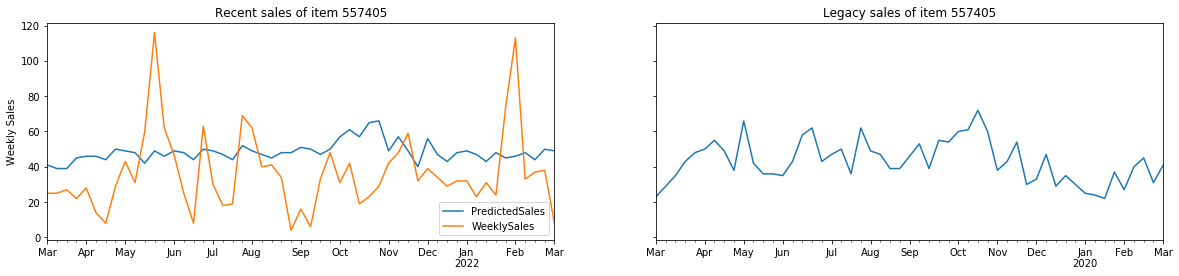

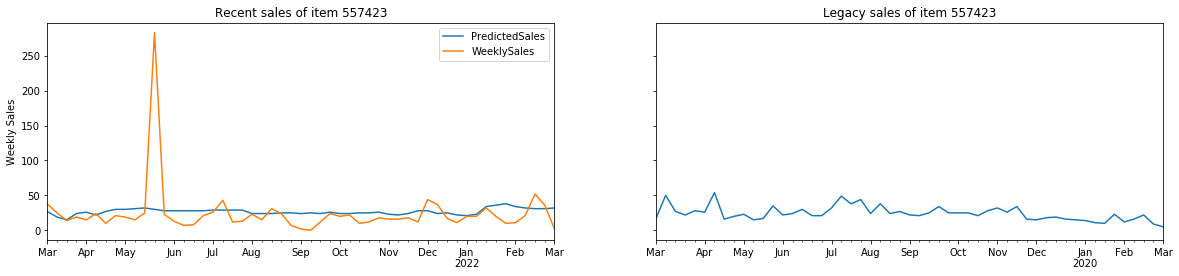

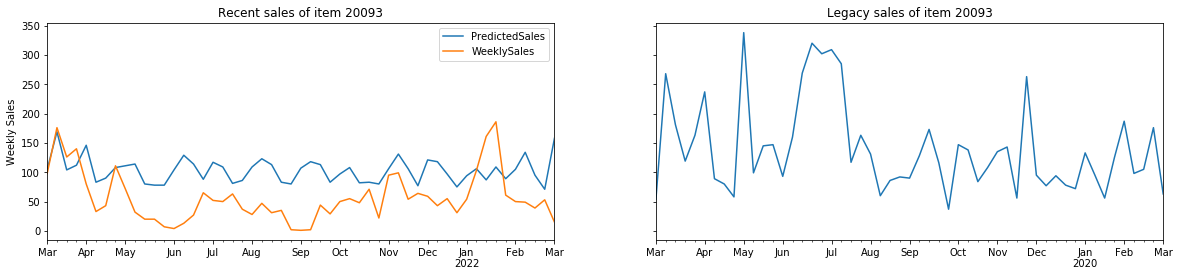

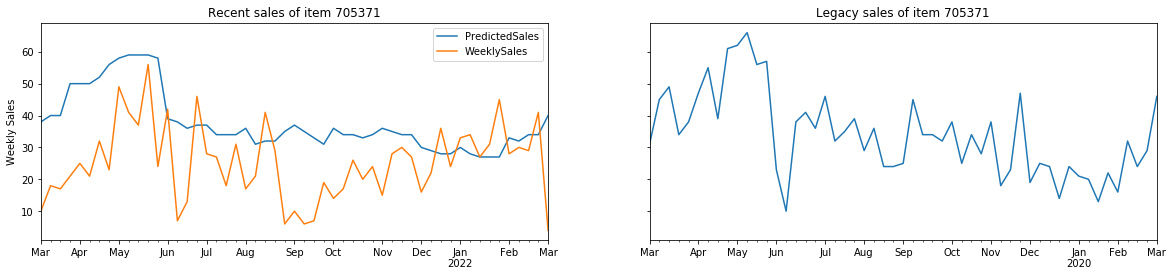

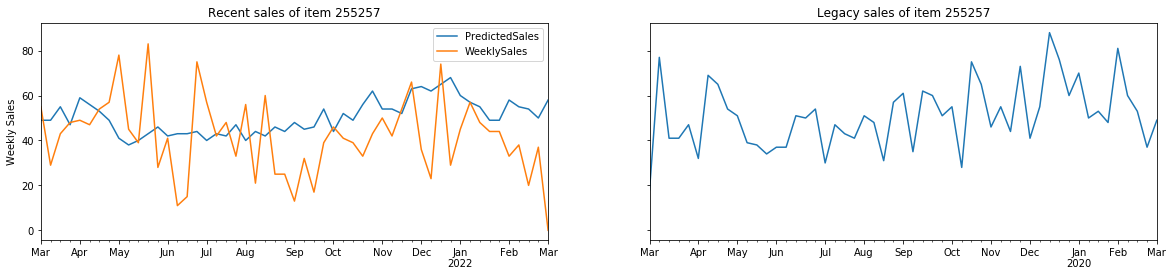

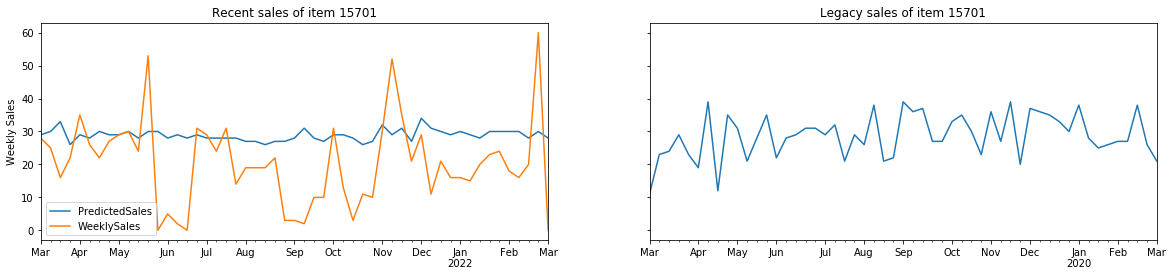

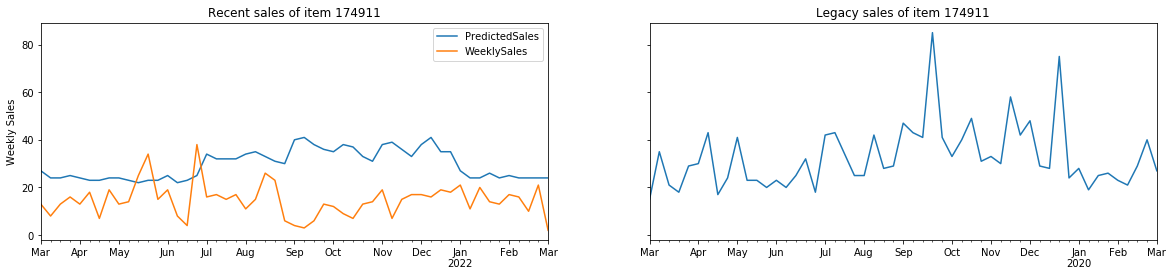

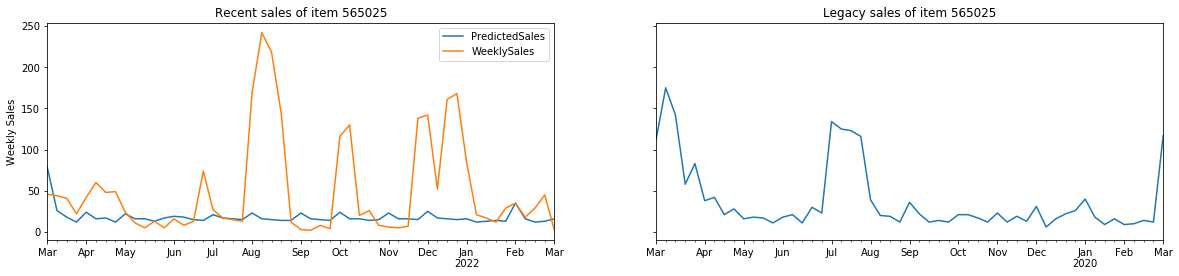

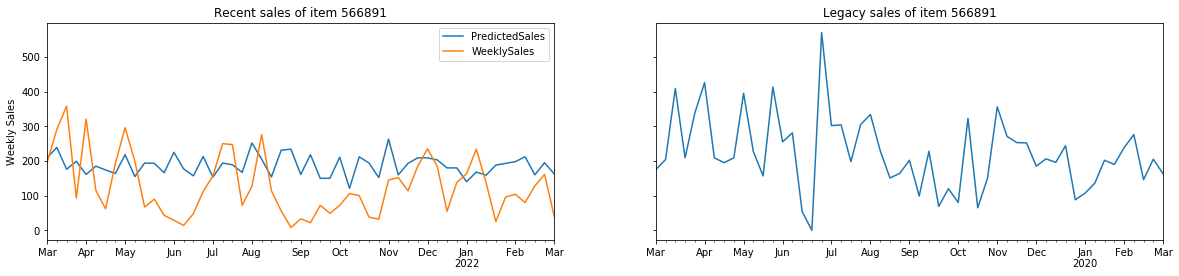

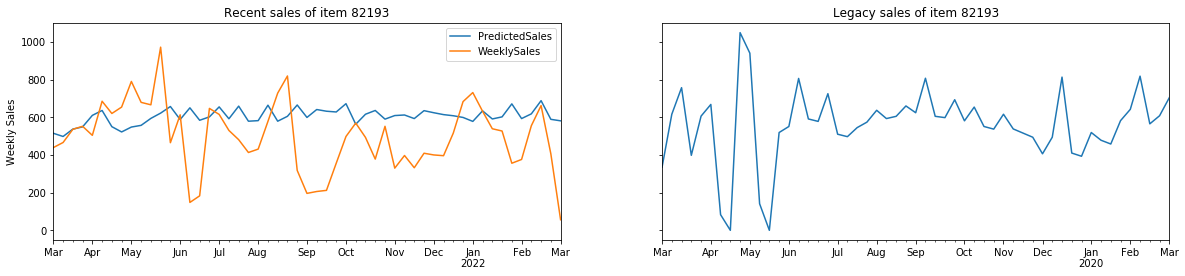

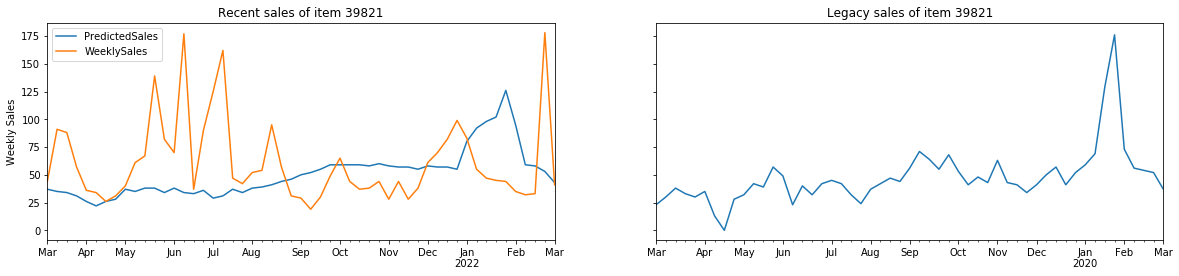

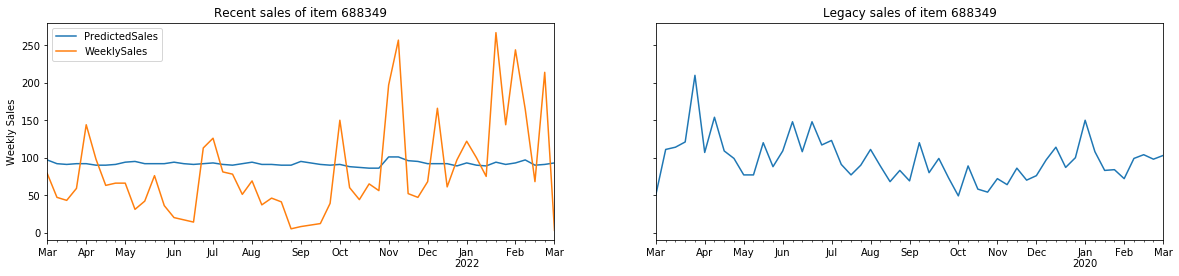

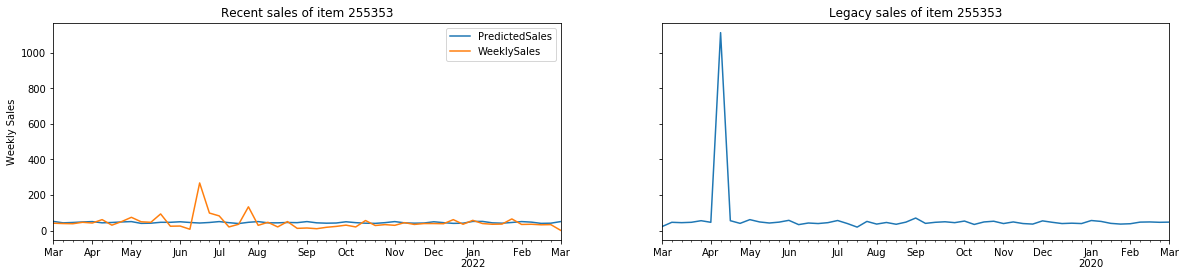

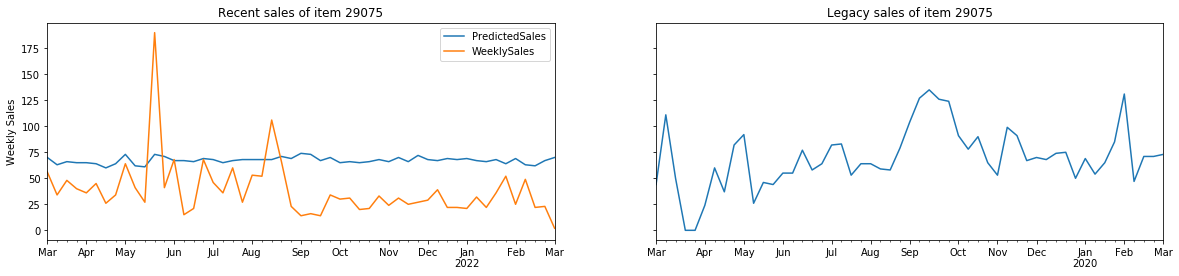

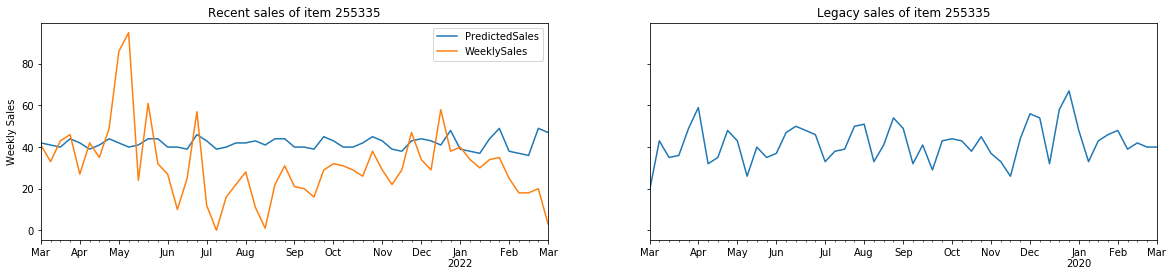

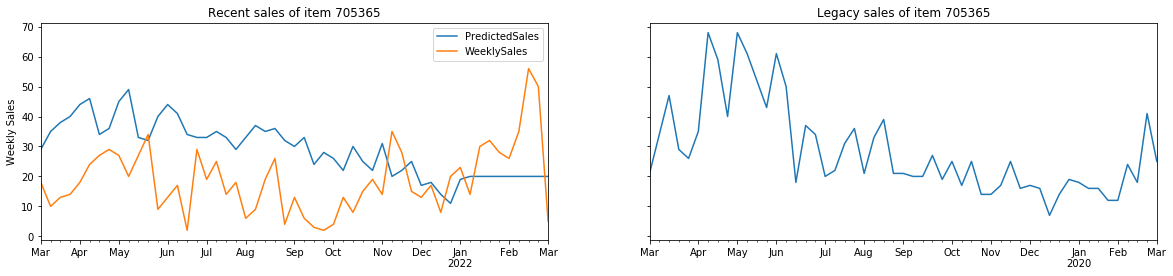

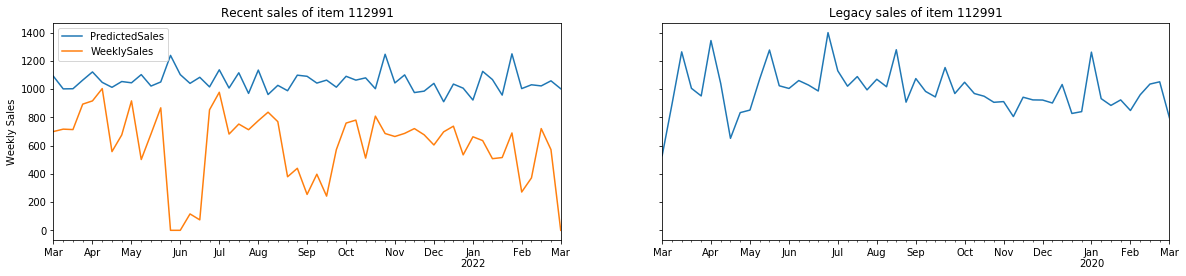

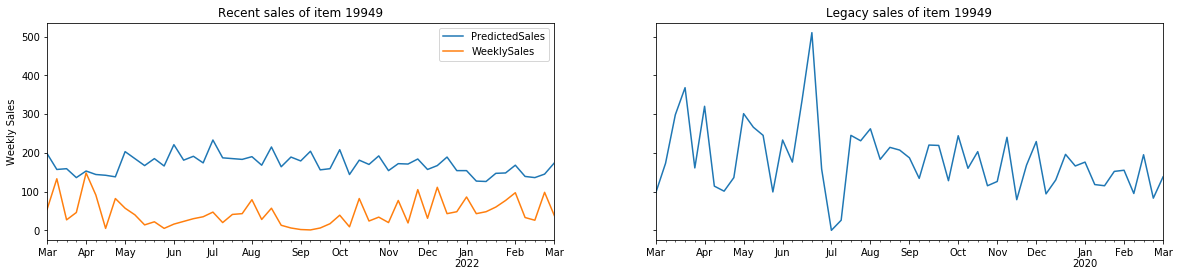

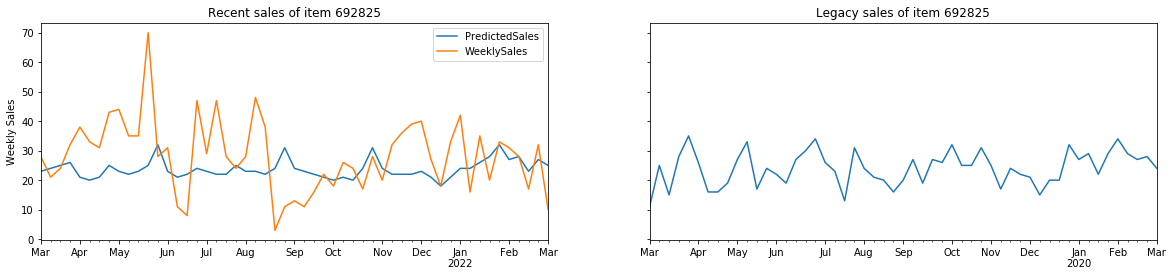

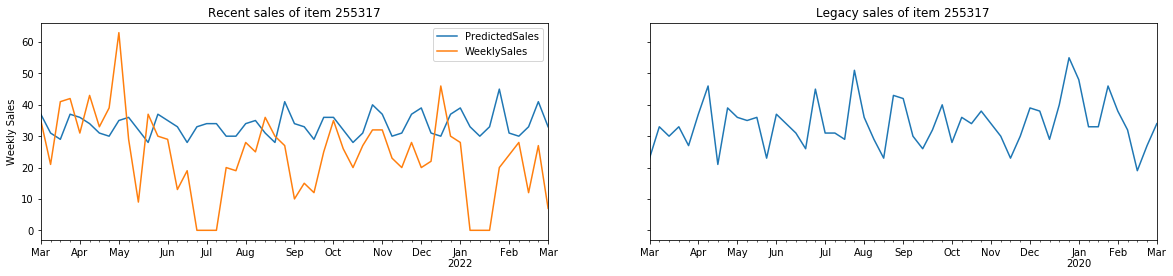

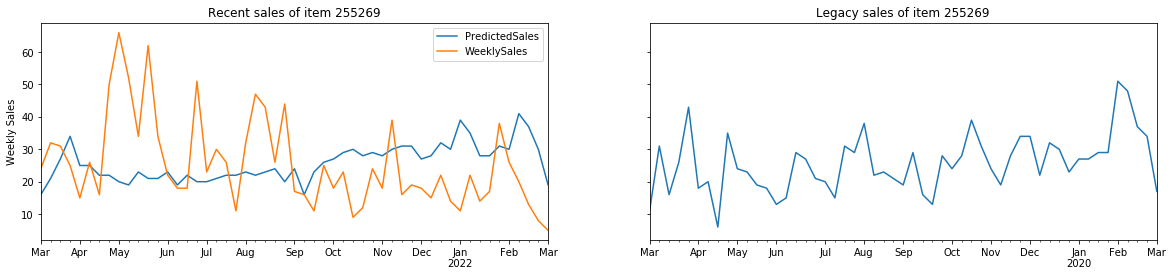

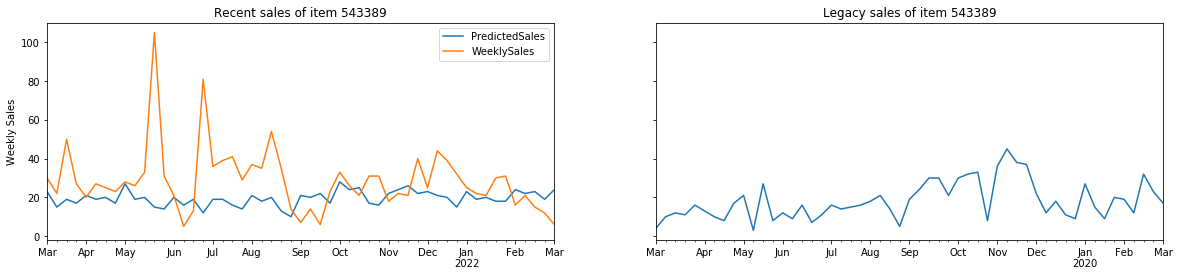

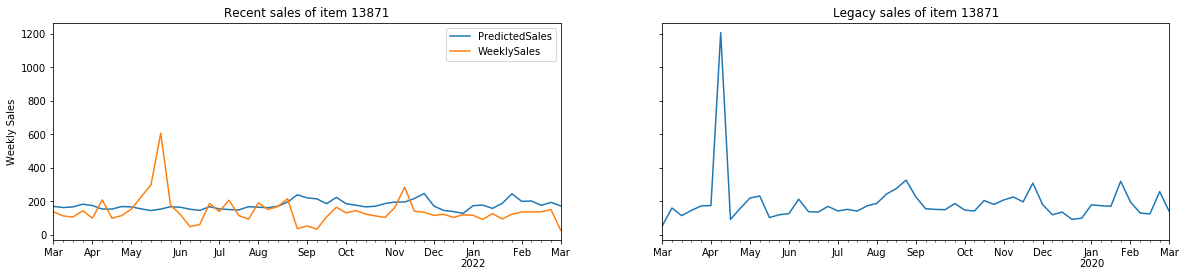

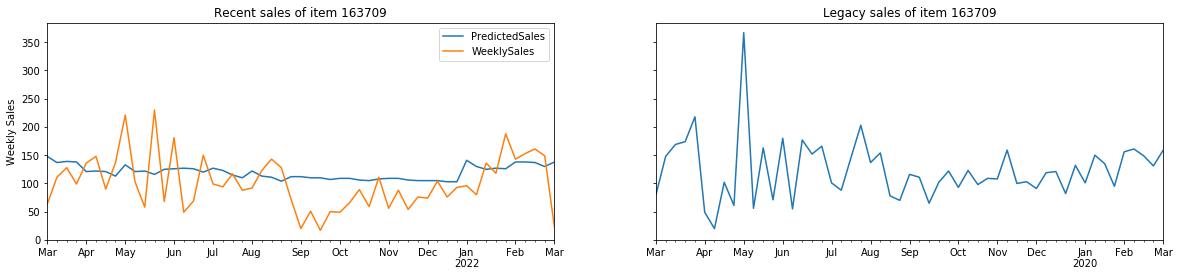

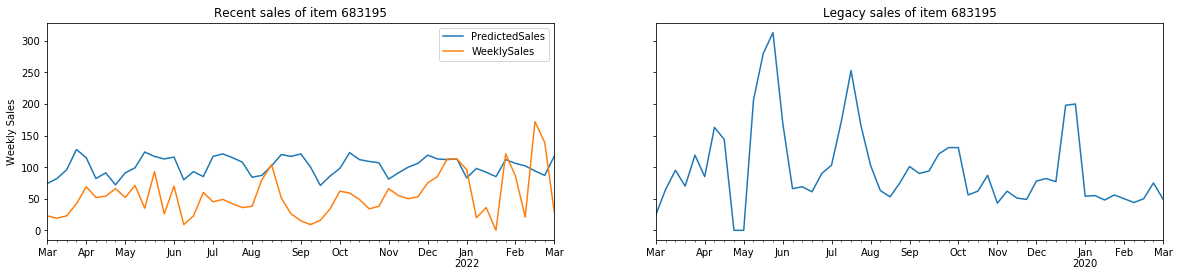

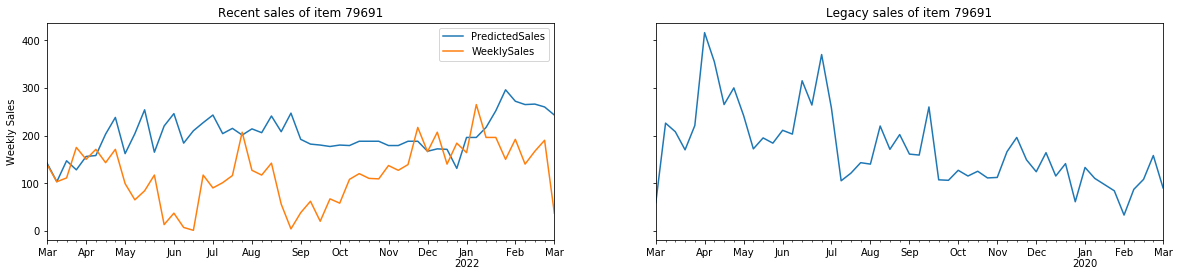

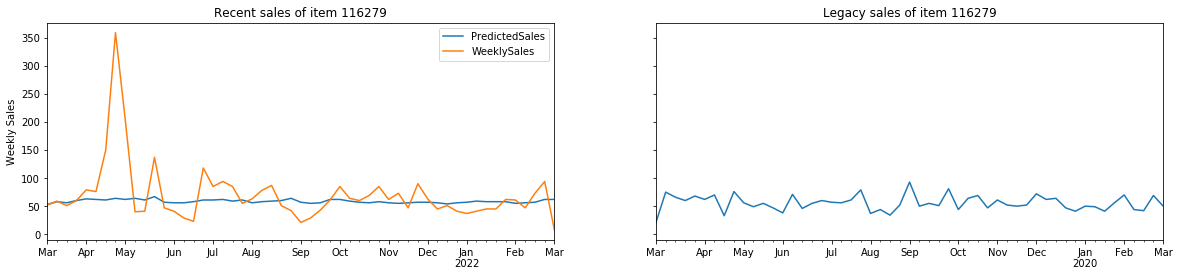

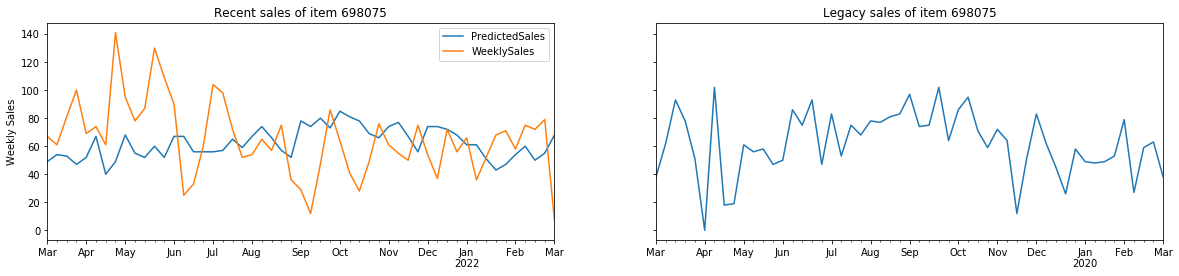

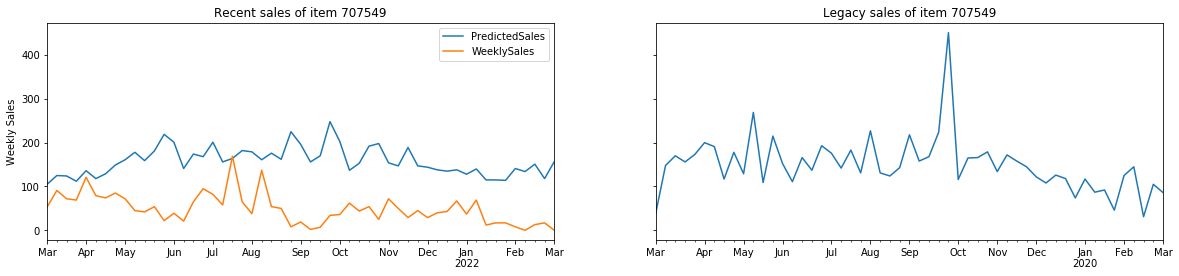

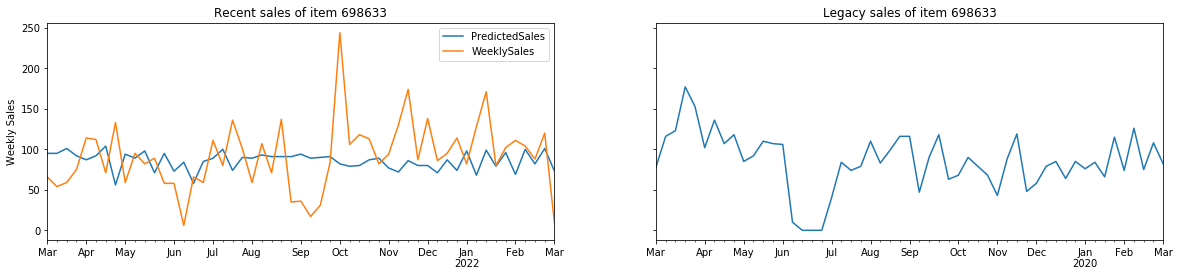

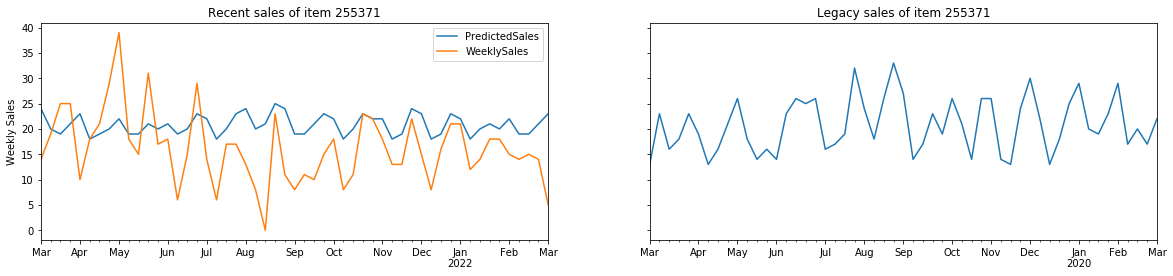

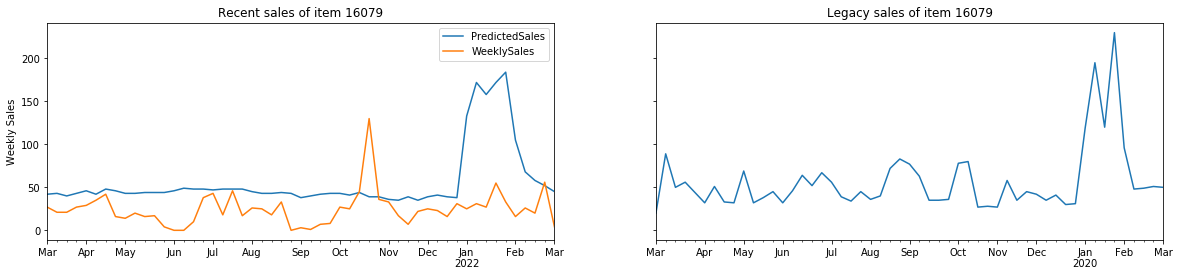

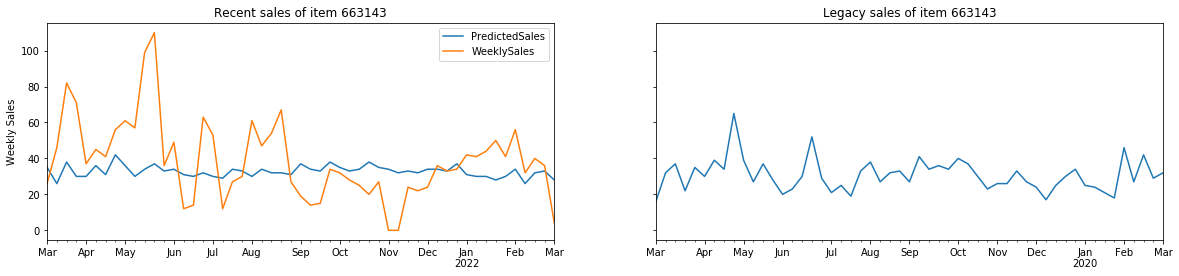

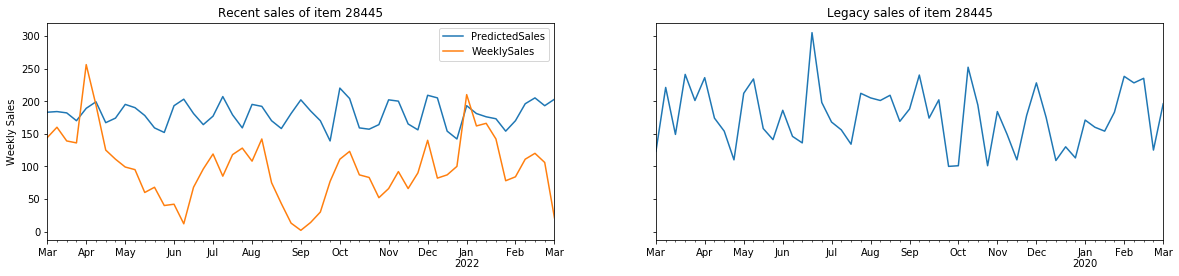

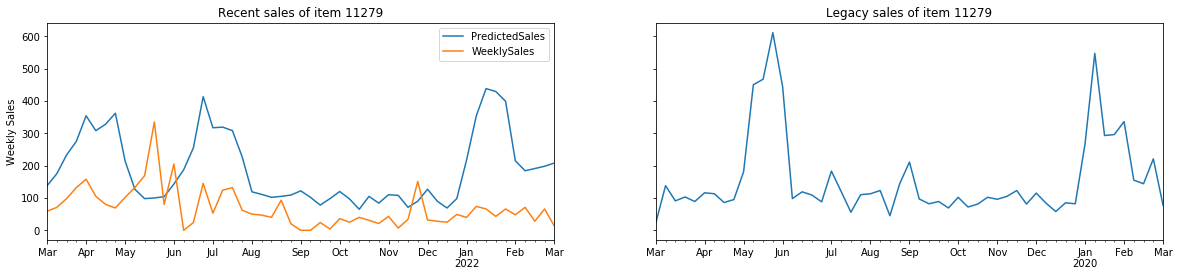

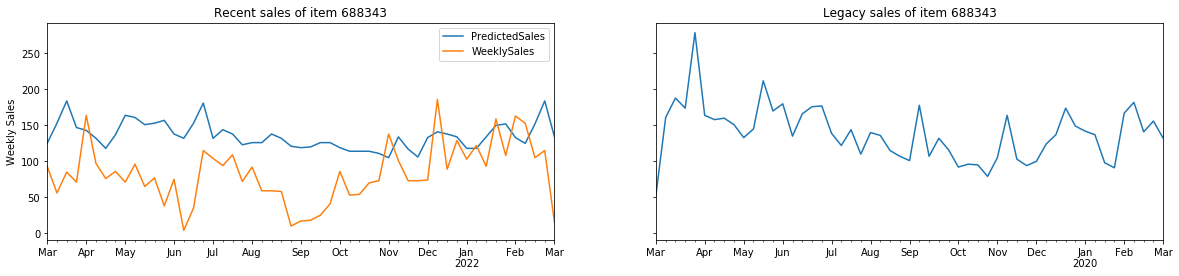

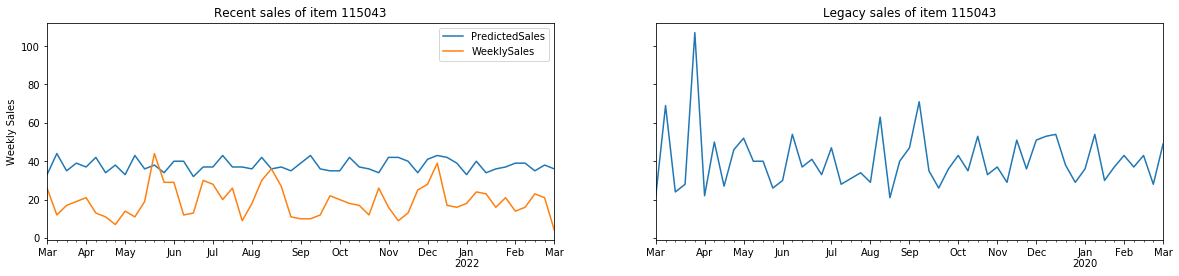

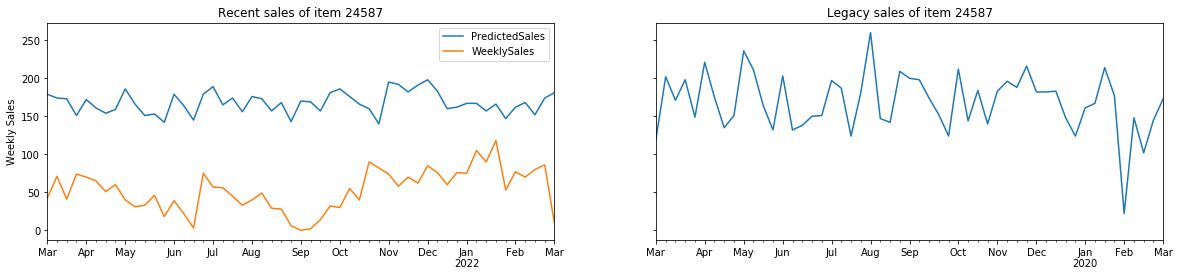

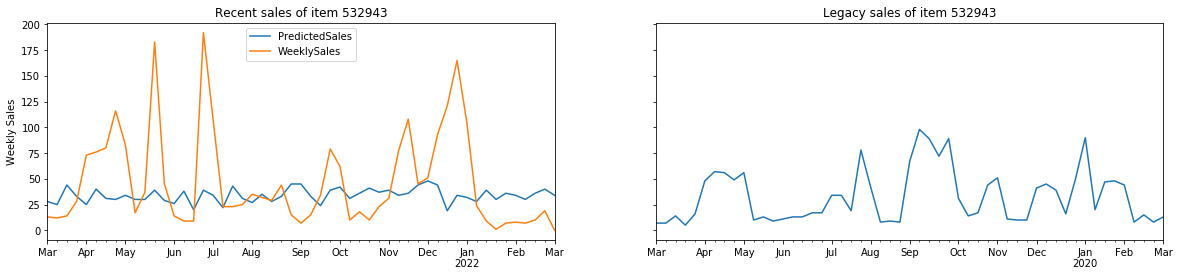

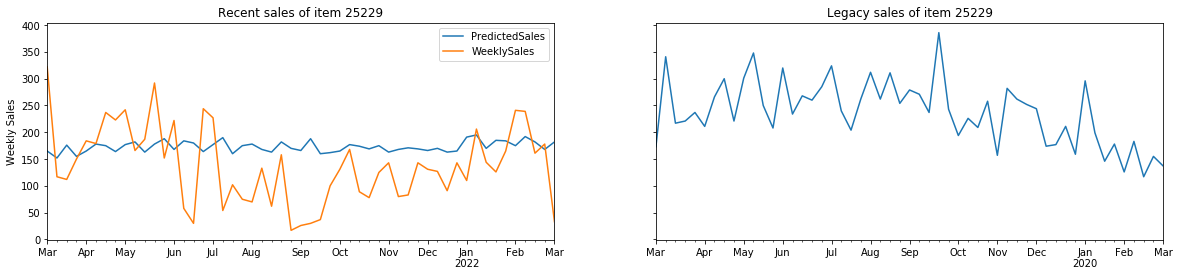

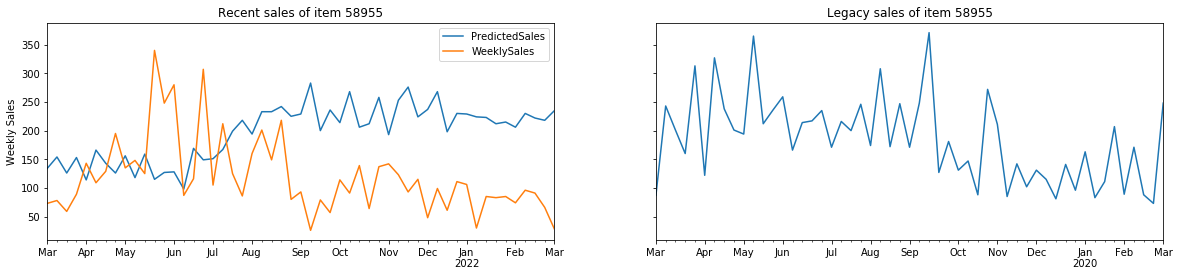

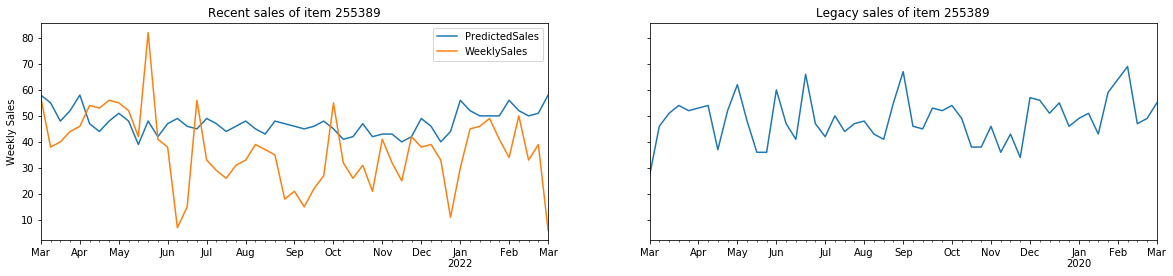

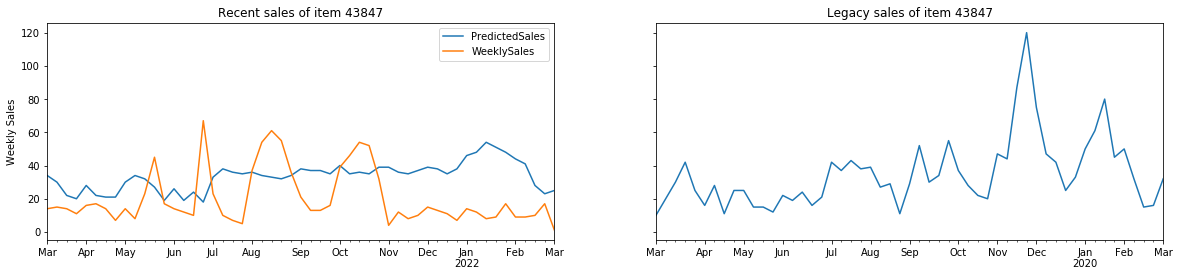

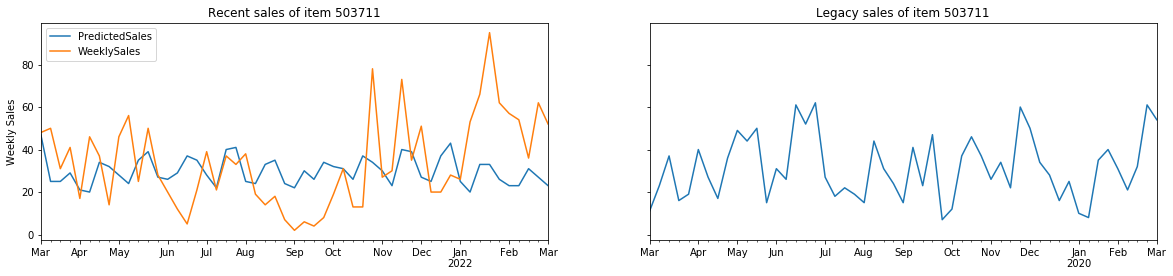

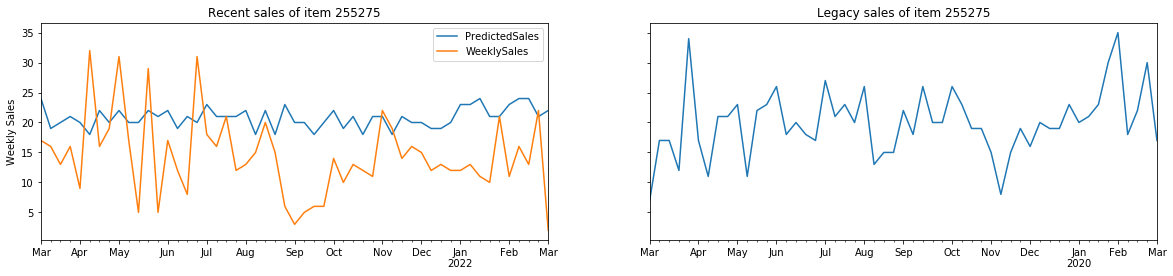

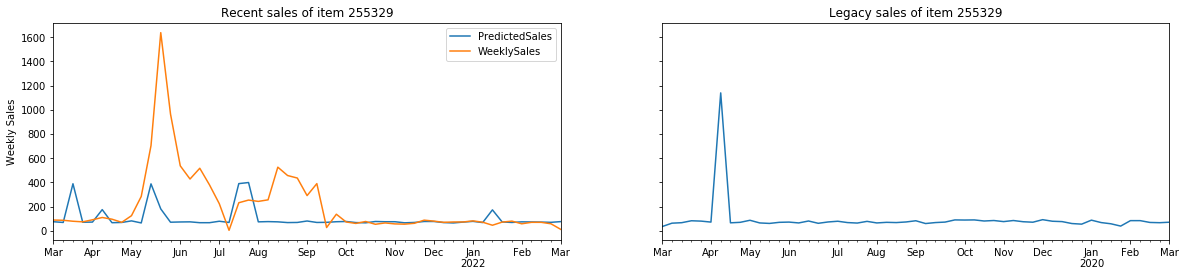

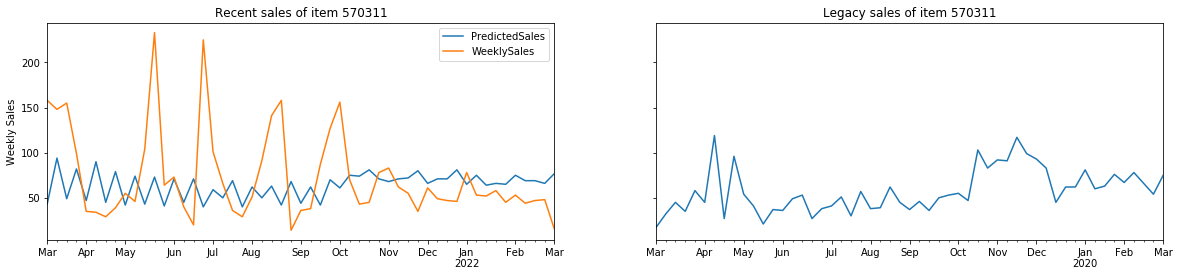

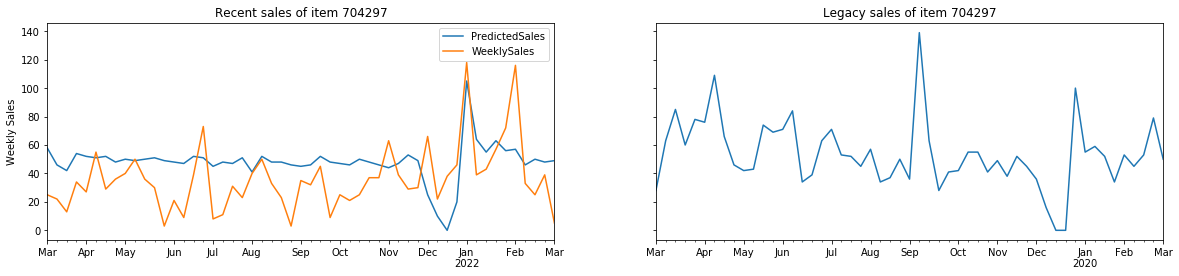

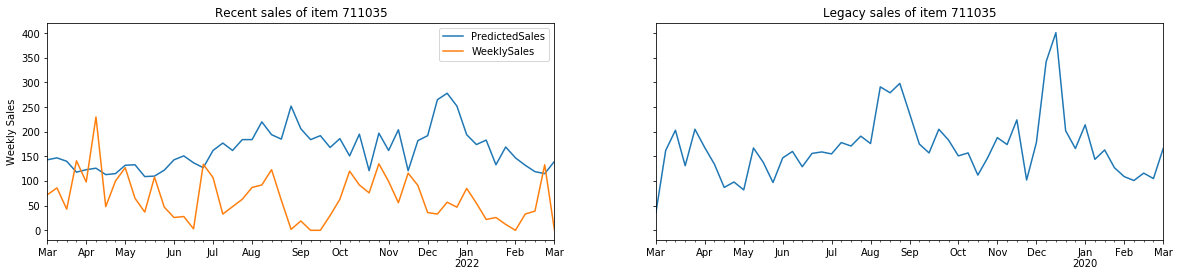

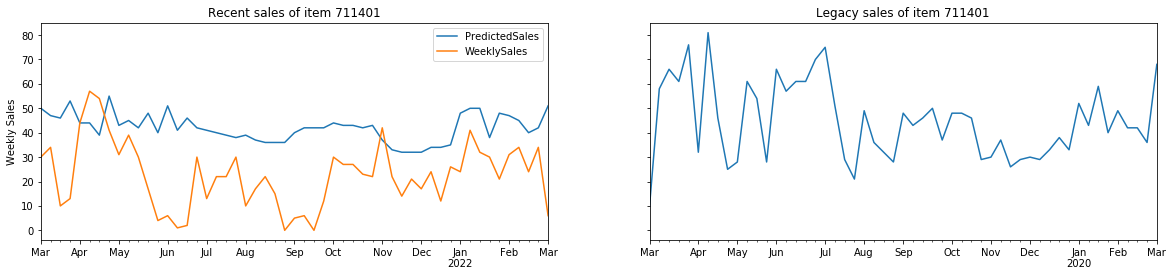

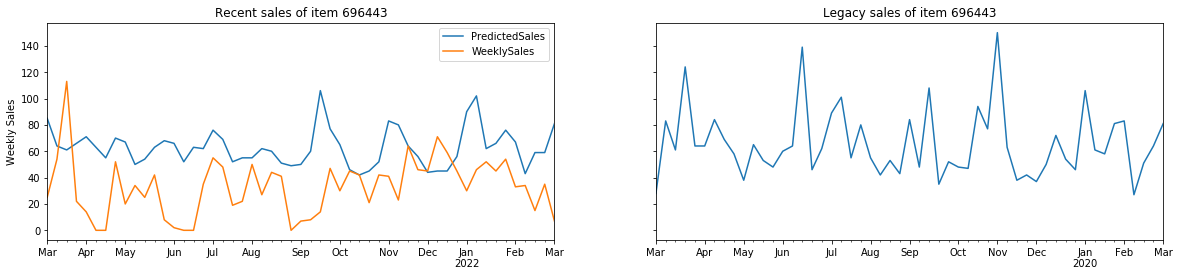

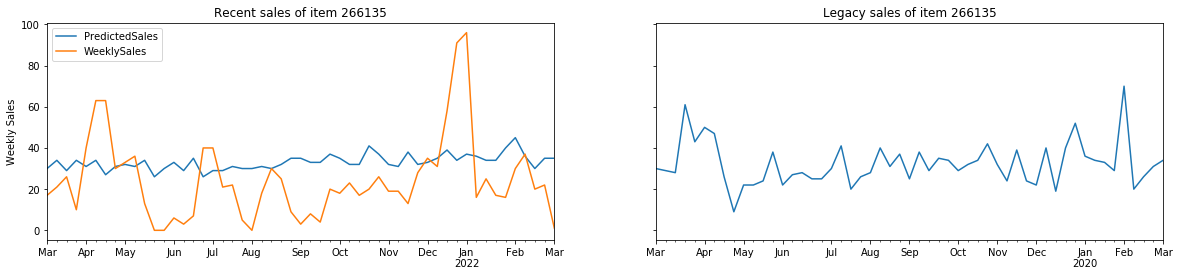

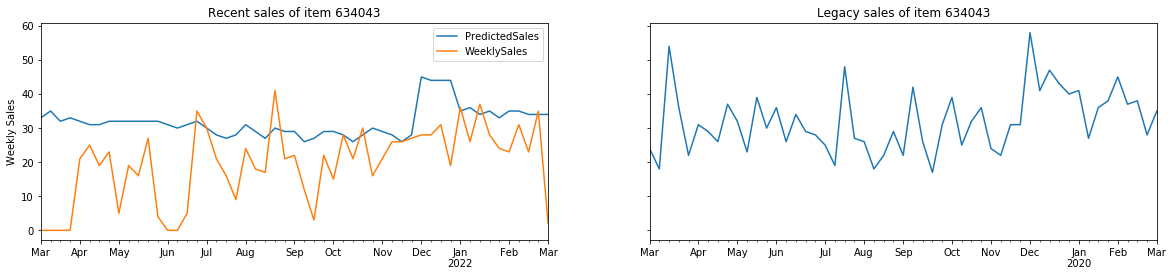

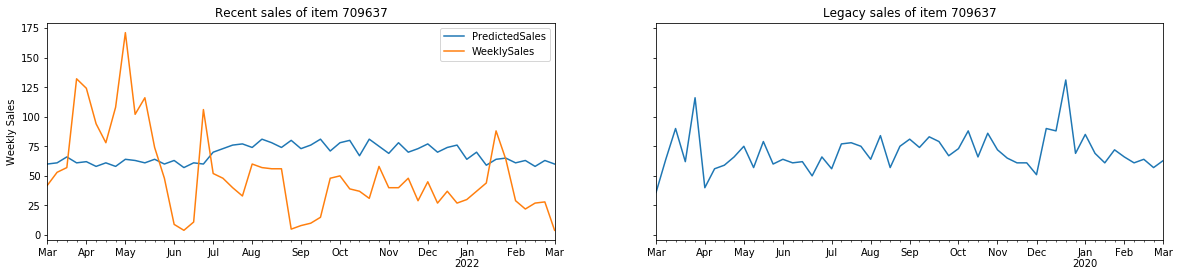

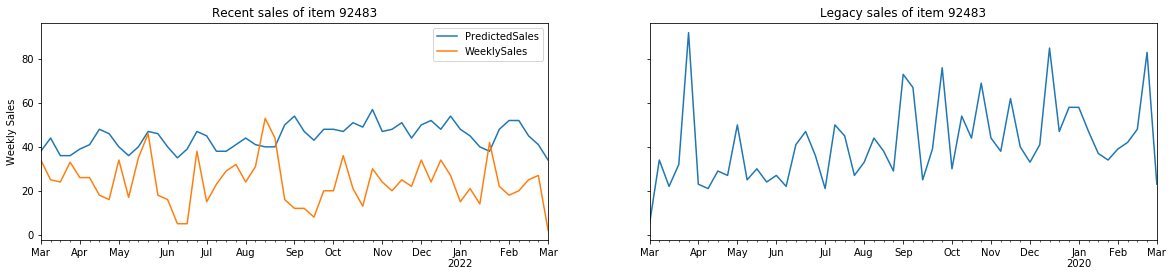

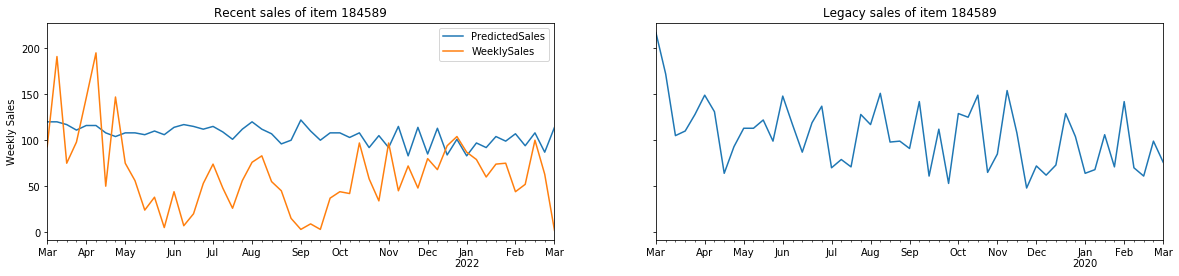

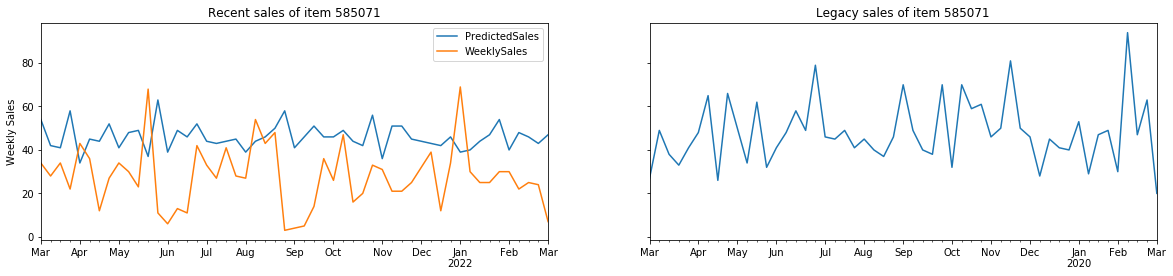

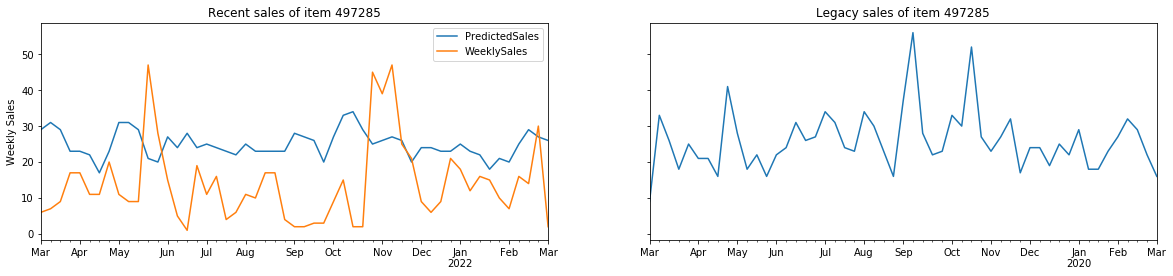

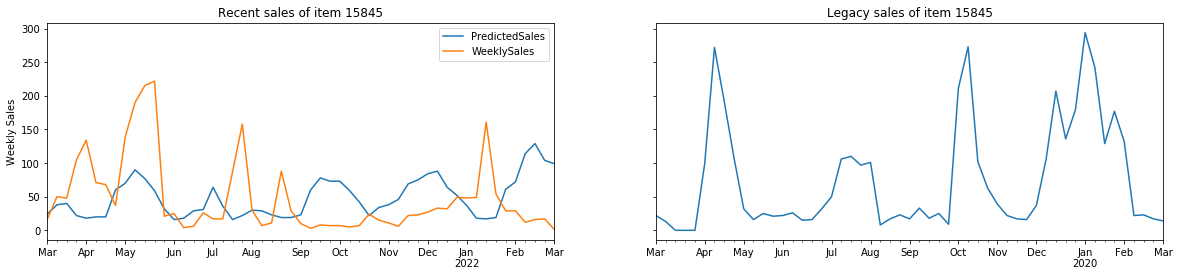

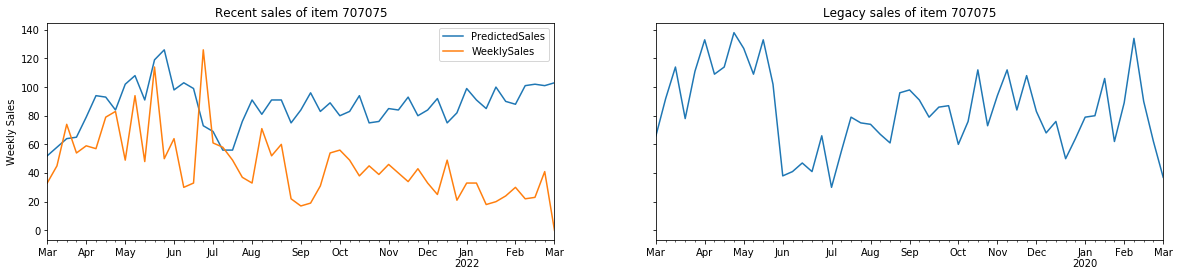

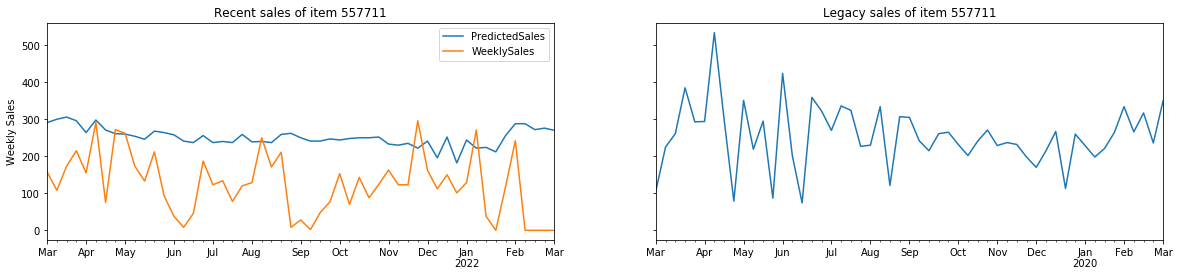

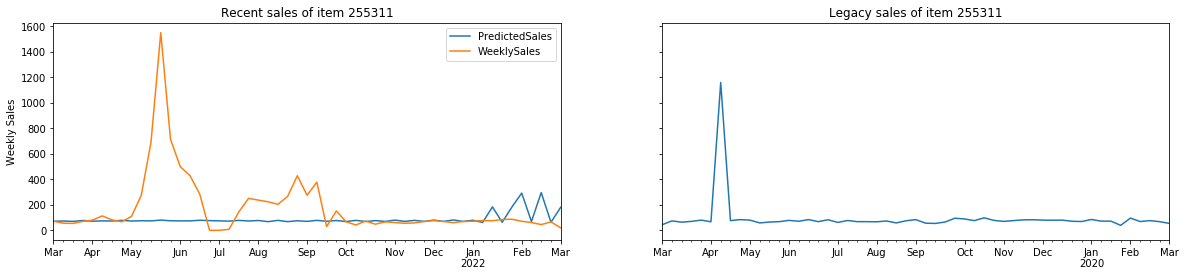

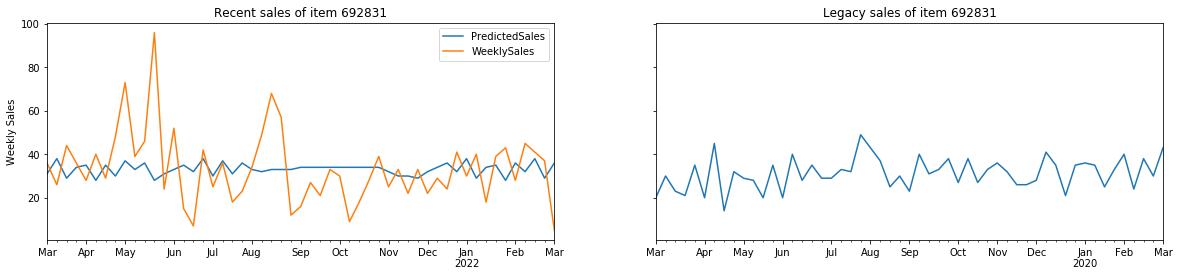

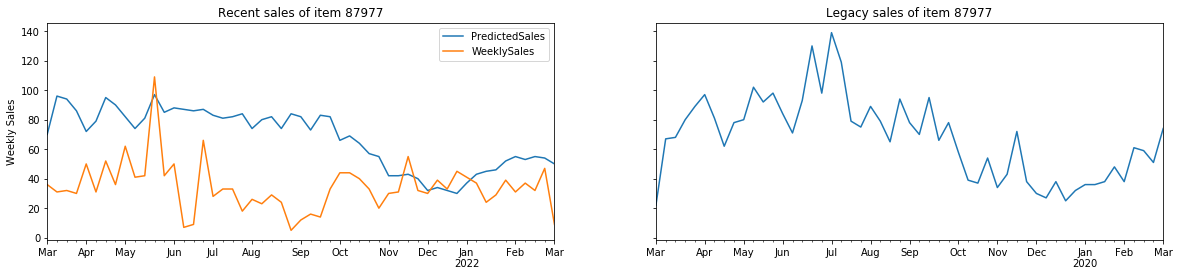

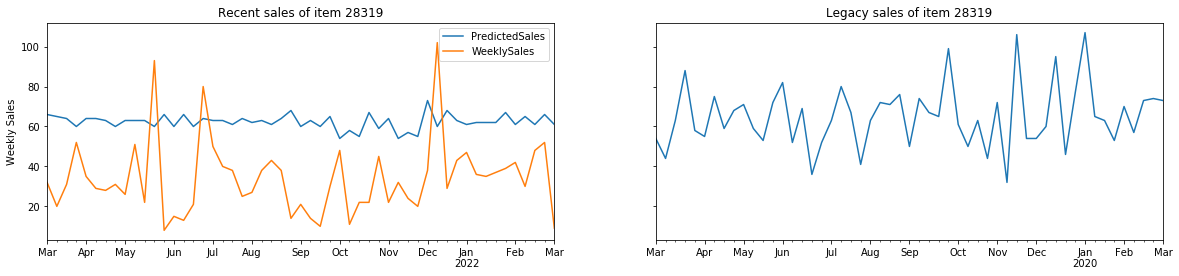

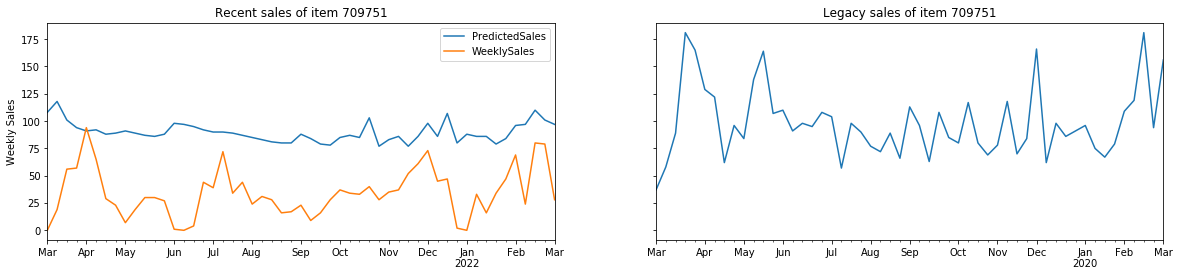

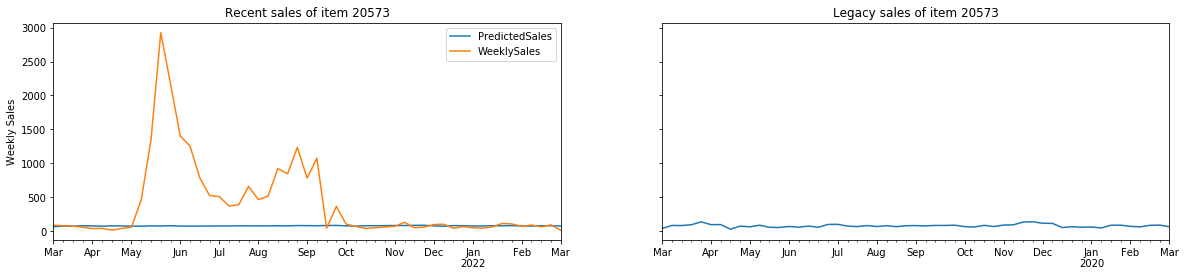

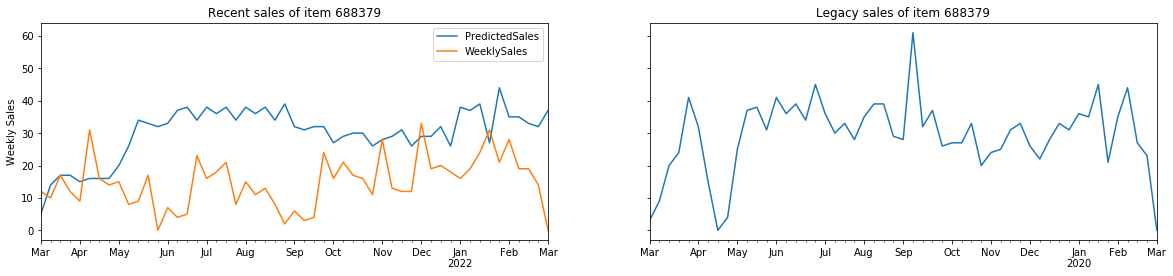

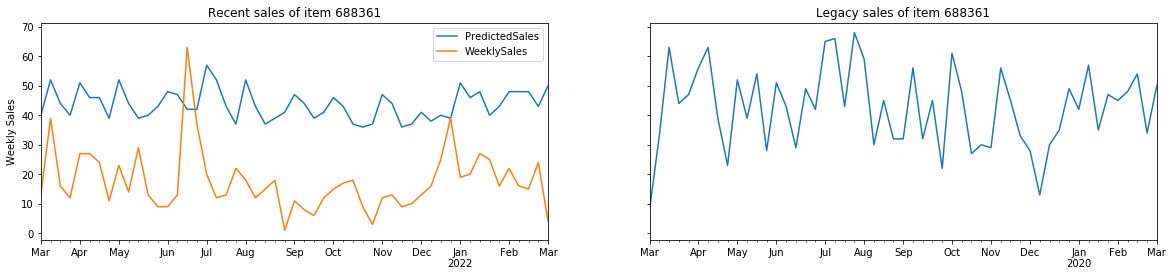

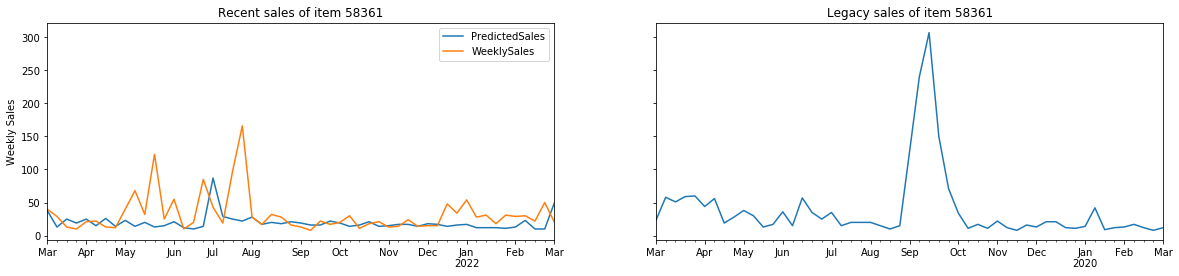

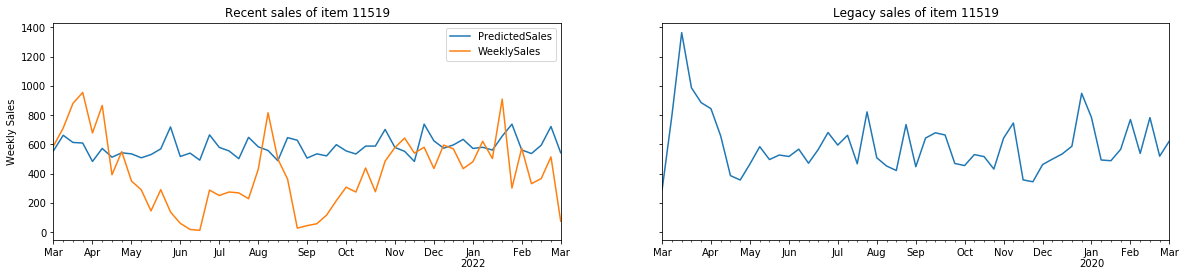

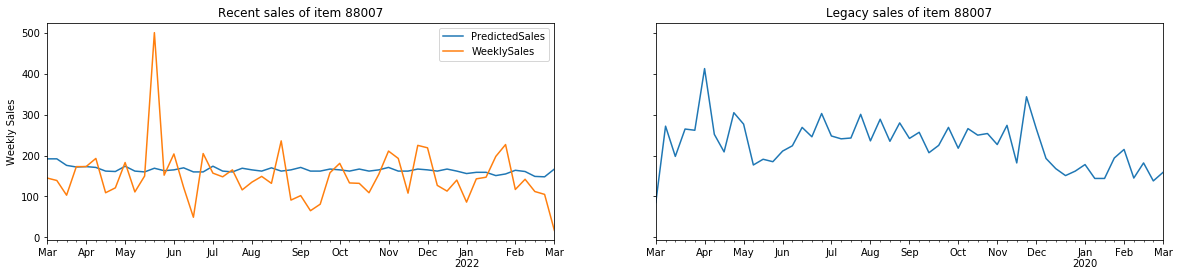

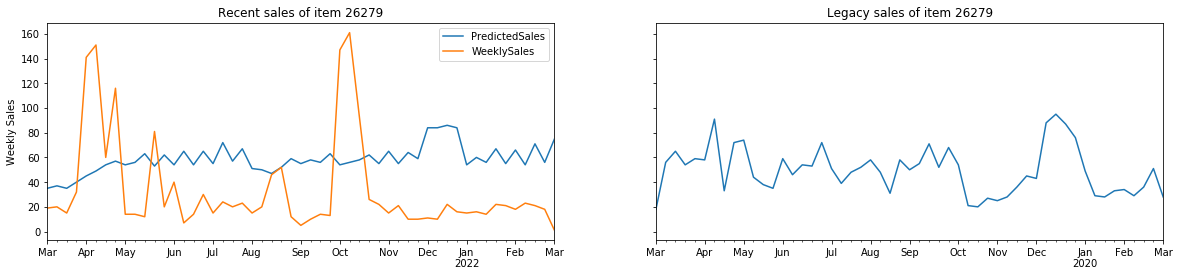

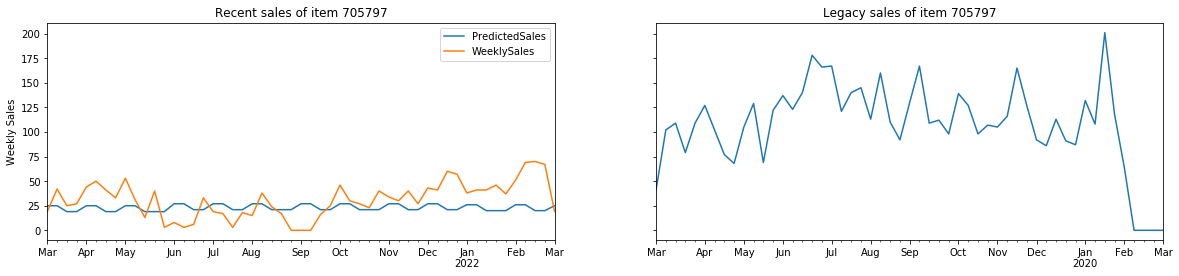

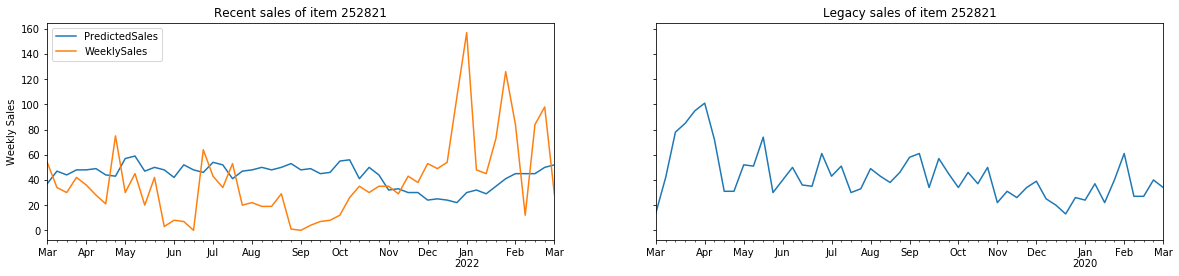

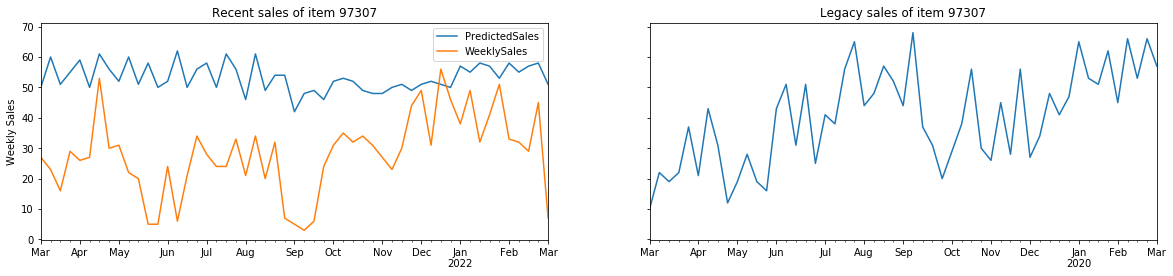

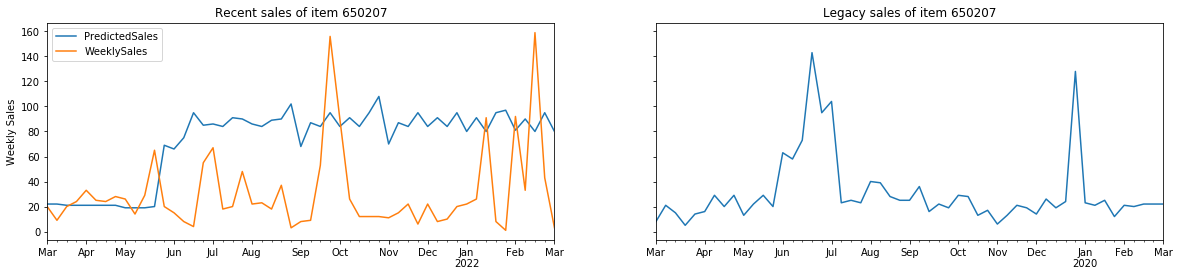

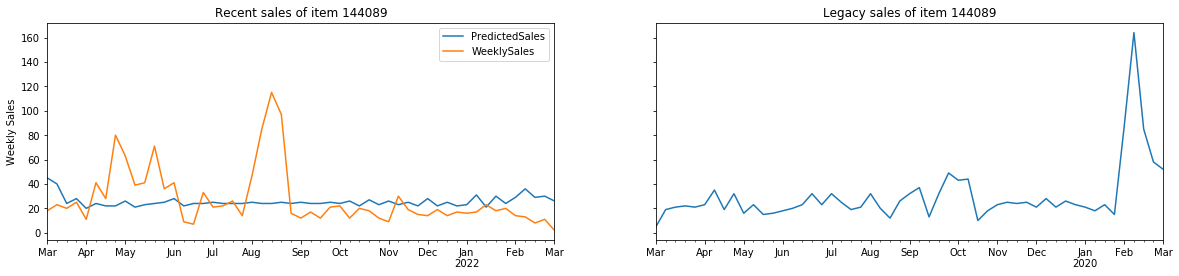

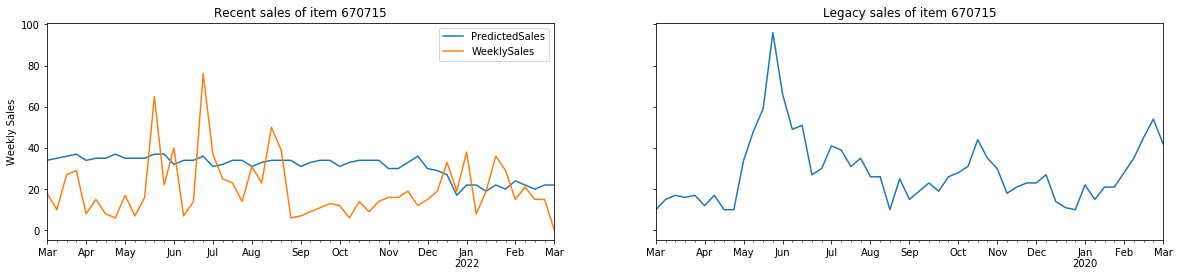

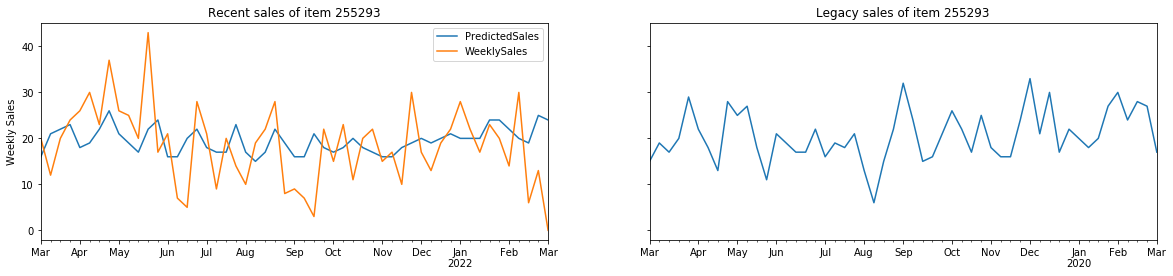

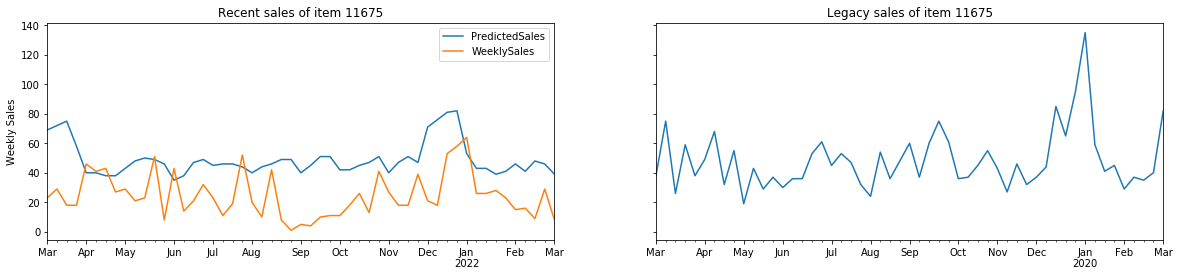

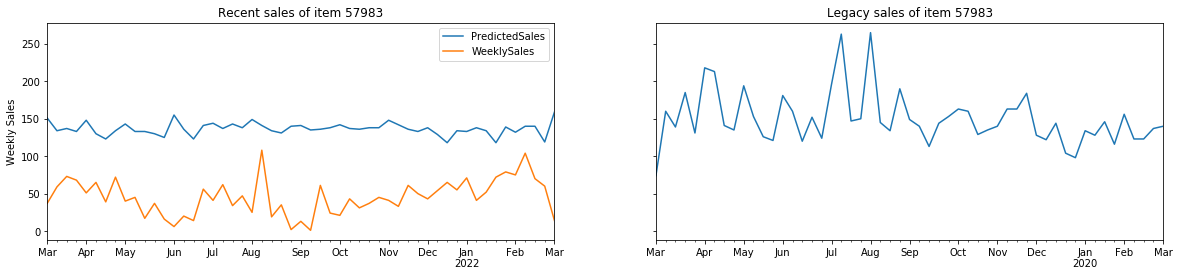

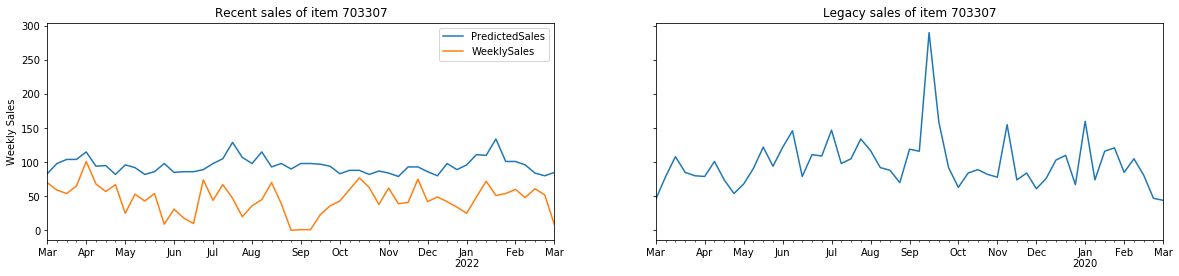

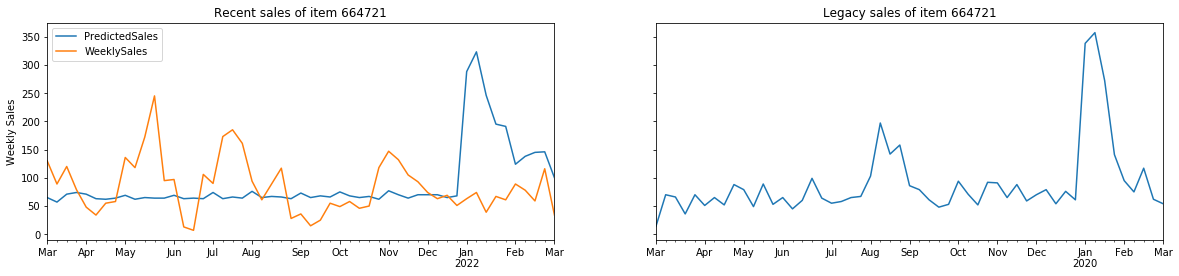

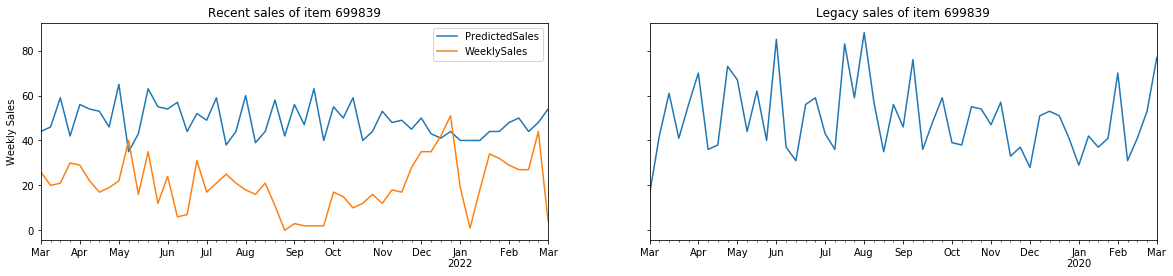

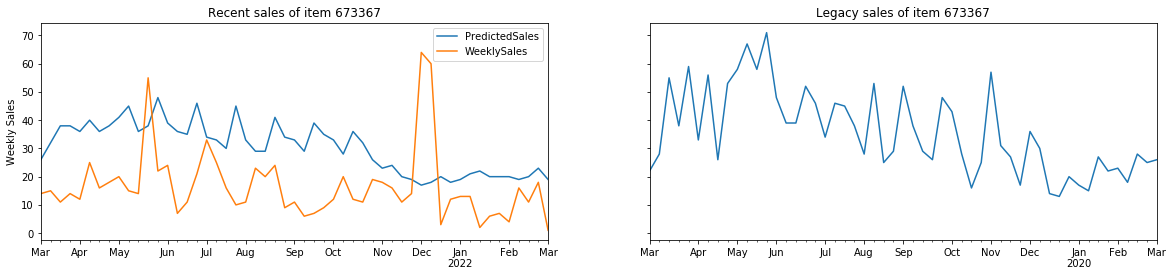

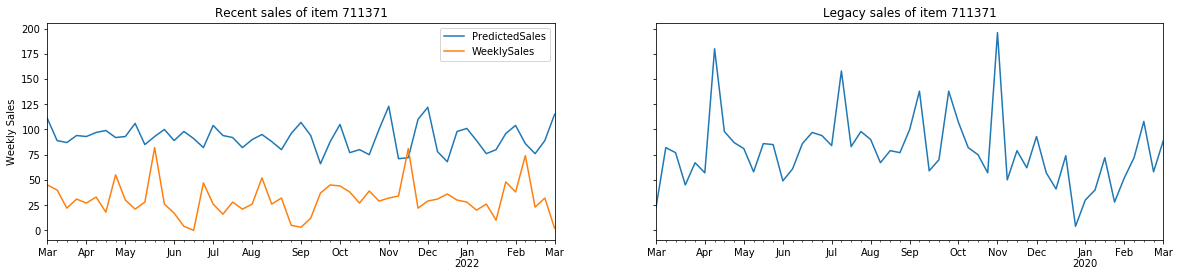

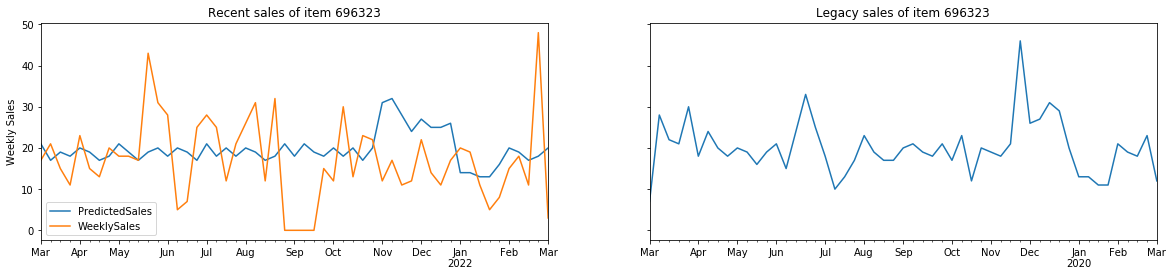

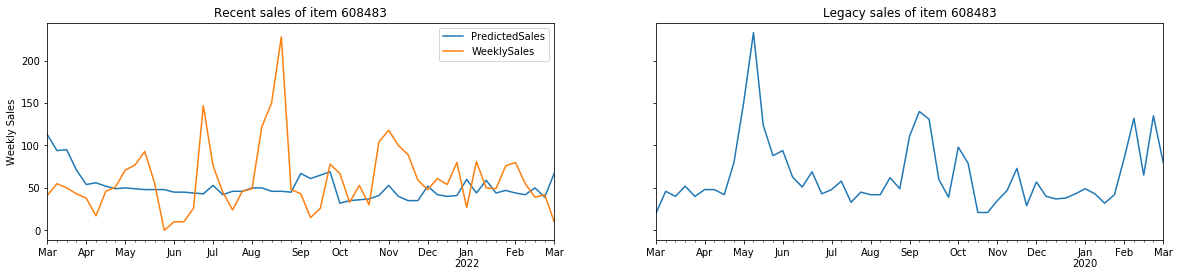

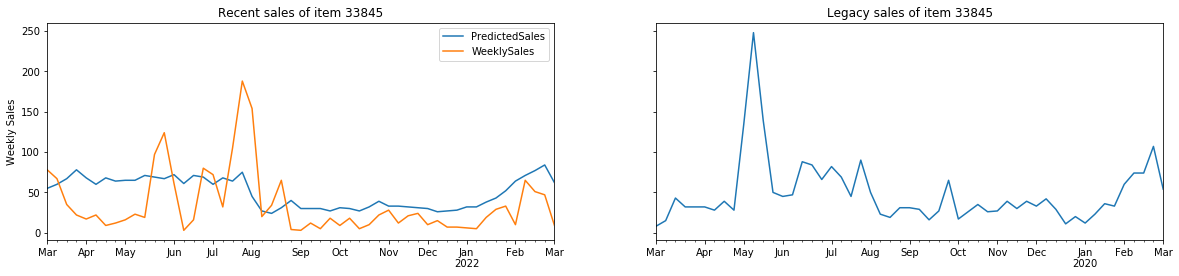

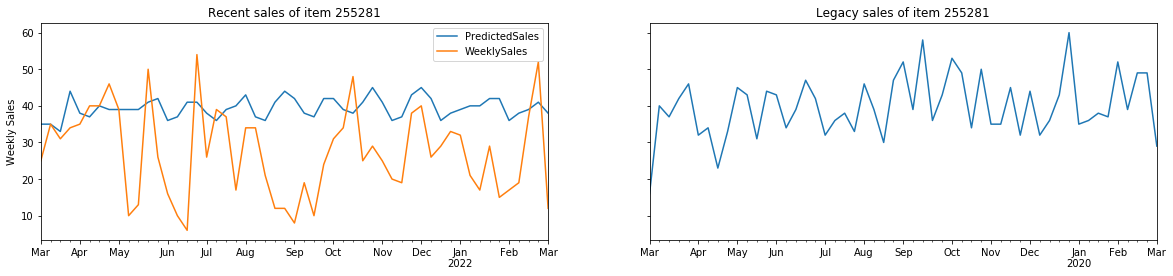

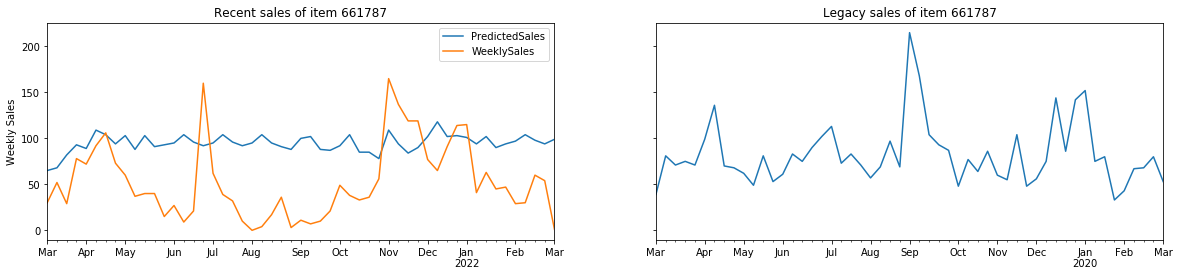

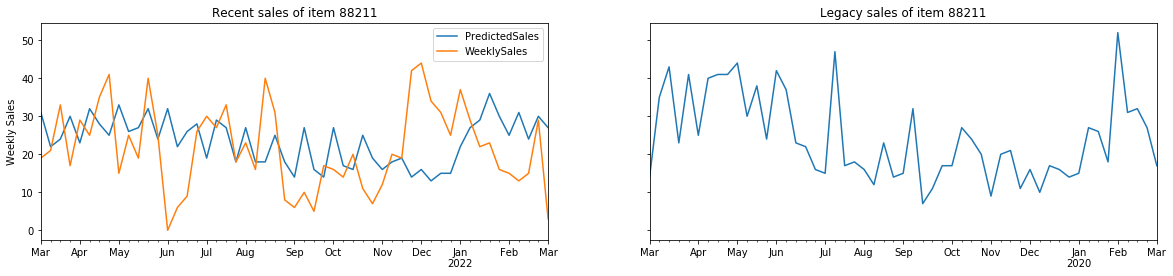

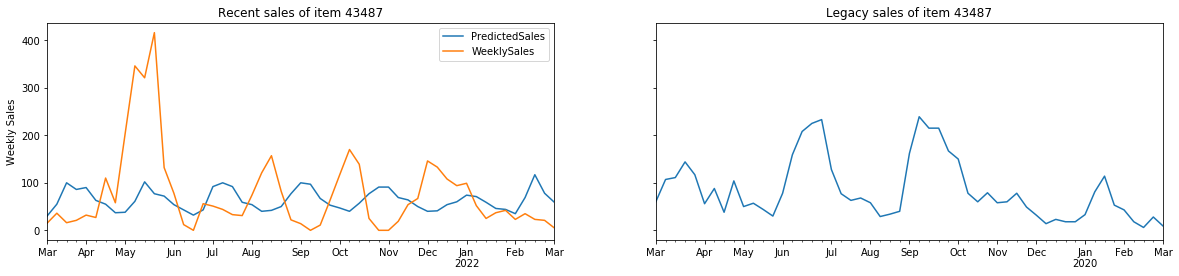

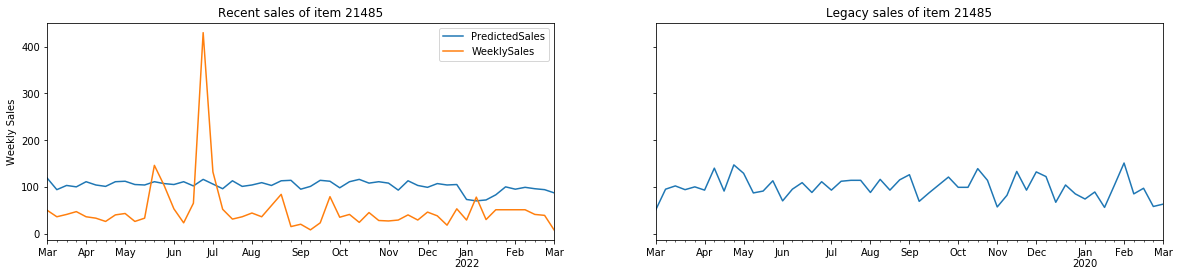

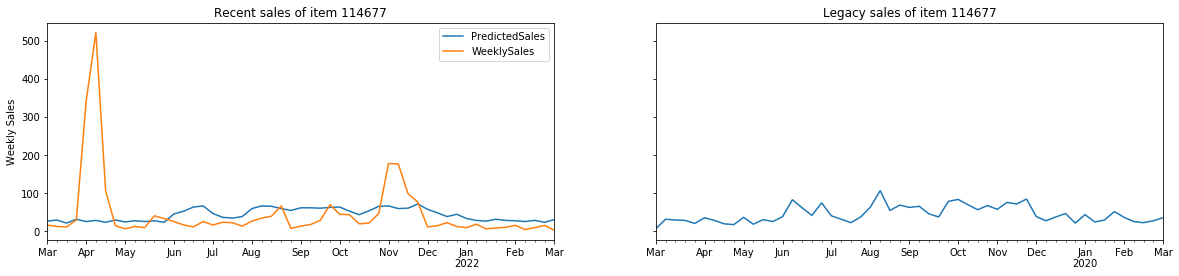

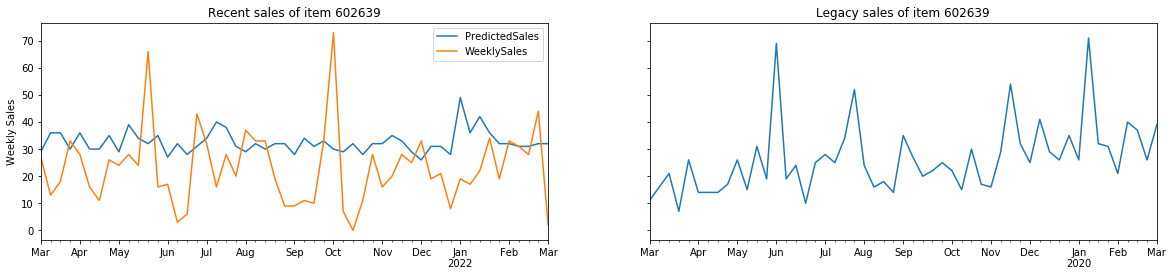

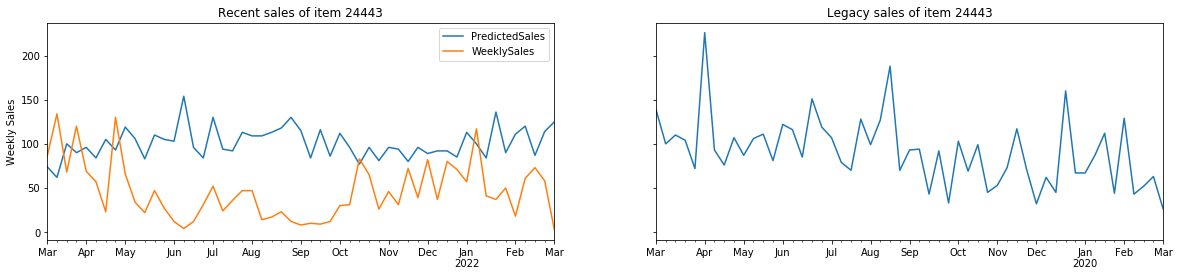

In [39]:
for item in df.ItemCode.unique():
    plot(item)